#### Installation of libraries not available as packages (Run only the first time you open this notebook)
It will restart the kernel once you run the cell below to be able to use the library src, just click Ok on the pop-up message about restarting the Kernel and continue running the next cell. Ignore the "Dead kernel" tag on the menu bar. 

In [2]:
{
    "tags": [
        "remove-output"
    ]
}
import sys,os
!git clone https://github.com/MICA-MNI/ENIGMA.git ._ENIGMA;cd ._ENIGMA;{sys.prefix}/bin/python setup.py install;rm -rf ../._ENIGMA
!git clone https://github.com/rmarkello/pyls.git ._pyls;cd ._pyls;{sys.prefix}/bin/python setup.py install;rm -rf ../._pyls
!{sys.prefix}/bin/pip install -e ../
#Restart the kernel after installing
os._exit(00)

#### Libraries loading

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import colorbar
import matplotlib.colors as clrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import os,glob,pickle,re,sys,json
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
import joypy
from nilearn import datasets, input_data
import pingouin as pg
import nibabel as nib
import pyls

import enigmatoolbox
from enigmatoolbox.utils.parcellation import surface_to_parcel,parcel_to_surface

#BrainSmash
from brainsmash.mapgen.base import Base 
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp


plt.rcParams['font.sans-serif'] = ['Open Sans']+plt.rcParams['font.sans-serif']
sns.set_context("notebook", font_scale=1.9)
sns.set_style("whitegrid")

import src.functions
%load_ext autoreload
%autoreload 2


#### Variables declaration and filepaths

In [2]:
if sys.platform=='darwin': 
    os.environ["PATH"]+=':/Applications/workbench_v1.4.2/bin_macosx64'
    os.environ["QT_QPA_PLATFORM"]='offscreen'

os.environ["OUTDATED_IGNORE"]='1'
os.environ["TMP"]=os.path.join(os.environ["HOME"],'tmp')
import tempfile
tempfile.tempdir=os.environ["TMP"]

root_dir = '../data'
results_dir = '../results'
#!lh_dist_full = np.loadtxt('ext_data/brainsmash/example_data/LeftParcelGeodesicDistmat.txt')

conn_metric = 'degree'#'degree' 'dti' 'alff' 'gmvar' shannon_entropy
dc_type = 'weighted'#'weighted' #binarize
pet_metric = 'cmrglc'
atlas_suf = 'mmp'
vol_res = '3mm'
vol_space = 'mni-'+vol_res
dc_z = '_z' 
y_var = pet_metric
x_var = conn_metric+dc_z
xlabel='dFC [Z-score]'
ylabel='CMRglc [umol/(min*100g)]'
fig_res_dpi = 150
generate_surf = False if (('BINDER_SERVICE_HOST' in os.environ.keys()) & ('workbench' not in os.environ["PATH"])) else True

#### Atlas

In [3]:
mmp_n = 360
N = '7'
n = '400'
yeo_suf = n+'_'+N+'N'
atlas_info = pd.read_csv(os.path.join(root_dir,'external','Schaefer2018_'+yeo_suf+'_order.txt'),sep='\t',header=None)
atlas_info['network'] = atlas_info[1].str.split('_').str.get(2)
nw_label2id = dict(zip(atlas_info['network'].unique(),range(1,int(N)+1)))
nw_id2label=dict(zip(range(1,int(N)+1),atlas_info['network'].unique()))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
atlas_roi2nw = dict(zip(atlas_info[0].tolist(), atlas_info['network_id']))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
yeo2mmp = enigmatoolbox.utils.parcellation.surface_to_parcel(enigmatoolbox.utils.parcellation.parcel_to_surface(atlas_info['network_id'].to_numpy(),
                                                                                                                'schaefer_{}_conte69'.format(n)),
                                                             'glasser_360_conte69',red_op='mode')
atlas_dict={}
atlas_dict['roi2network'] = dict(zip(range(1,int(mmp_n)+1),np.vectorize(nw_id2label.get)(yeo2mmp[1:].astype(int)).flatten()))
yeo_colors = np.array(pd.read_csv(getattr(datasets.fetch_atlas_yeo_2011(),'colors_'+N),sep='\s+').iloc[:,2:5]/255)
yeo_nw_colors = {nw_id2label[i+1]: (yeo_colors[i,0],yeo_colors[i,1],yeo_colors[i,2]) for i in range(len(nw_id2label))} 
atlas_dict['nw2color'] = yeo_nw_colors
ignore_nws = ['Other','None',None,'Limbic']

#### Data loading

In [4]:
load_df = True
s = 0.1
sd_res_roi_df = pd.DataFrame({})

total_n_subj = 47
all_avg_vox_vals = pd.read_csv(os.path.join(root_dir,f'gx_all-cohorts_vox_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.csv'))
all_avg_roi_vals = pd.read_csv(os.path.join(root_dir,f'gx_all-cohorts_roi_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.csv'))
all_ind_vox_vals = pd.read_csv(os.path.join(root_dir,f'individual_all-cohorts_vox_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.csv.zip'))
all_avg_vox_vals_with_gx_mask = pd.read_csv(os.path.join(root_dir,f'gx_all-cohorts_vox_gx-mask_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.csv.zip'))
all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()

cohorts_metadata_fn = os.path.join(root_dir,f'gx_all-cohorts_data_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.pickle')
if not os.path.exists(cohorts_metadata_fn):
    !wget https://openneuro.org/crn/datasets/ds004513/files/derivatives:energetic-costs:gx_all-cohorts_data_nsubj-47_degree-weighted.pickle -O {cohorts_metadata_fn}
with open(cohorts_metadata_fn, 'rb') as f:
    cohorts_metadata = pickle.load(f)    

tum_participants_fn = os.path.join(root_dir,'._participants.tsv')
if not os.path.exists(tum_participants_fn):
    !wget https://openneuro.org/crn/datasets/ds004513/files/participants.tsv -O {tum_participants_fn}
tum_participants_info = pd.read_csv(tum_participants_fn,sep='\t')
vie_participants_info = pd.read_csv(os.path.join(root_dir,'external','Sundar2018','VIE_participants.tsv'),sep='\t')
age_participants_mapping = {**dict(zip(tum_participants_info.participant_id.str.split('-').str[1],tum_participants_info.age)),**dict(zip(vie_participants_info.participant_id.str.split('-').str[1],vie_participants_info.age))}
sex_participants_mapping = {**dict(zip(tum_participants_info.participant_id.str.split('-').str[1],tum_participants_info.sex)),**dict(zip(vie_participants_info.participant_id.str.split('-').str[1],vie_participants_info.sex))}


#### Colors

In [5]:
sel_cm = 'RdBu_r'
gray_c = [0.77,0.77,0.77,1]
extended_cm=np.concatenate((np.array([gray_c]),getattr(plt.cm,sel_cm)(np.arange(0,getattr(plt.cm,sel_cm).N))))

### Figure 1. Energy metabolism scales linearly with brain connectivity
#### 1A. Multimodal brain imaging

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 134, 135, 164, 165, 166, 172]
Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 134, 135, 164, 165, 166, 172]
11451.64 ± 1135.62 cortical voxels across all subjects


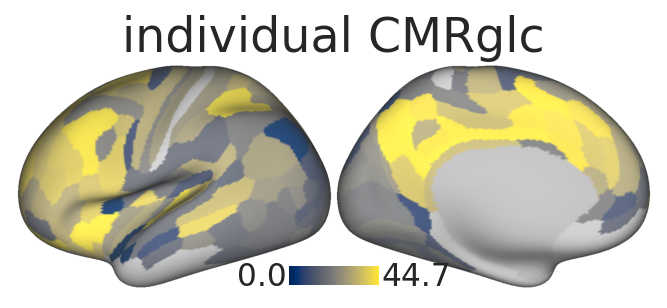

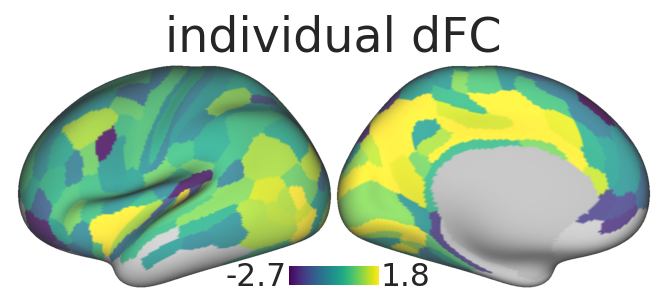

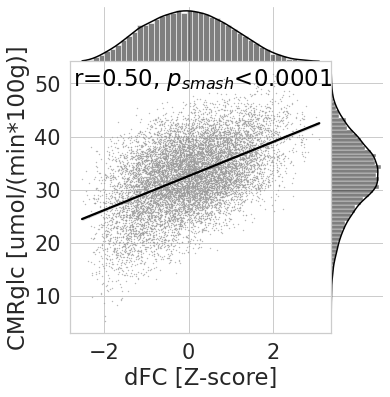

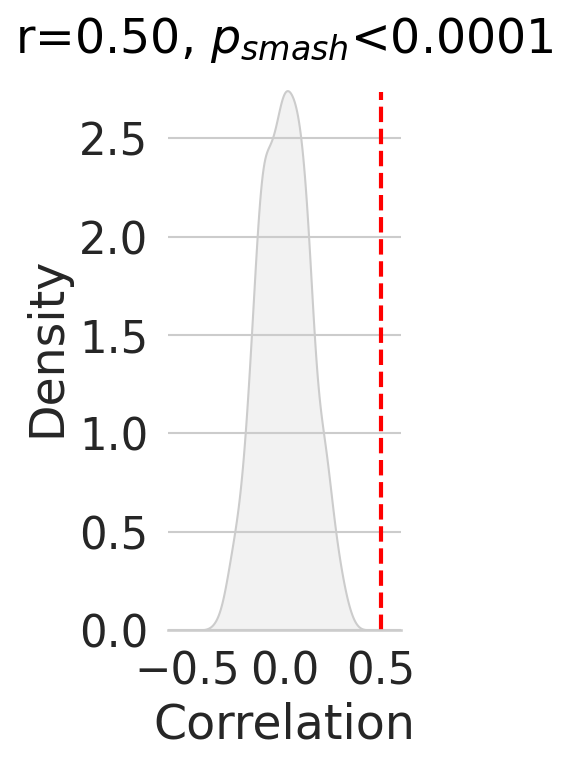

<Figure size 900x600 with 0 Axes>

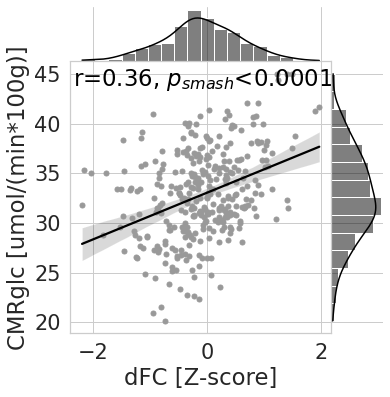

In [6]:
reference_site = 'TUM'
reference_cohort = 'exp1'
example_sid = 20
example_ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==cohorts_metadata[reference_site][reference_cohort]['sub_pref'] % example_sid) & (all_ind_vox_vals.cohort==f'{reference_site}.{reference_cohort}')].copy()

## Surface representation
src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,y_var,'roi_id'),os.path.join(results_dir,'figures',f'fig1A_surf-{y_var}'),
          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual CMRglc',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)
src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,x_var,'roi_id'),os.path.join(results_dir,'figures',f'fig1A_surf-{x_var}'),
          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'viridis')(np.arange(0,getattr(plt.cm,'viridis').N))))),
          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual dFC',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)


## Individual voxelwise scatterplot
r_vox_param,_=stats.pearsonr(example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),x_var],example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),y_var])
p_vox_np = nonparp(r_vox_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_vox_np = p_vox_np if p_vox_np>0 else 0.00001
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)
print(f'{all_ind_vox_vals.groupby(["sid","cohort"],as_index=False).count().roi_id.mean():.2f} ± {all_ind_vox_vals.groupby(["sid","cohort"],as_index=False).count().roi_id.std():.2f} cortical voxels across all subjects')

## Smash random distribution
plt.figure(figsize=(2,5),dpi=fig_res_dpi)
src.functions.plot_rnd_dist(cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'],
                            r_vox_param,p_vox_np,plt.gca(),xlabel=xlabel,ylabel=ylabel,xlim=(-0.5,0.5),print_text=True)

## Individual ROIwise scatterplot
example_ind_roi_vals = example_ind_vox_vals.groupby('roi_id').median()
r_roi_param,_=stats.pearsonr(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var])
p_roi_np = nonparp(r_roi_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_roi_np = p_roi_np if p_roi_np>0 else 0.00001
plt.figure(dpi=fig_res_dpi)
g = src.functions.plot_joint(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var],s=25,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_roi_np)


#### 1B. Group analysis voxelwise | S1 FC/DynFC/SC ROIwise

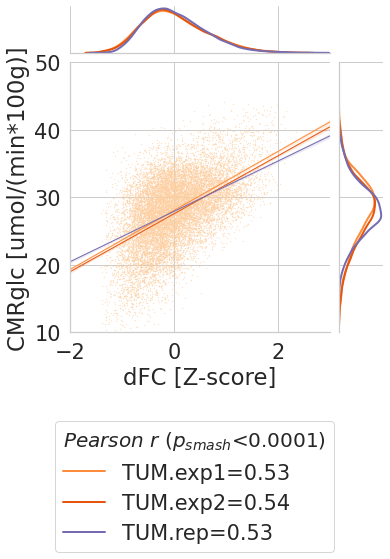

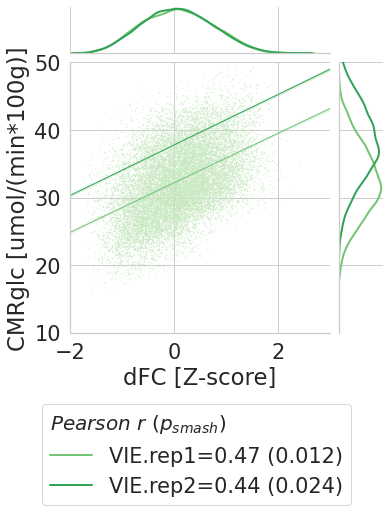

In [7]:
roiwise_results = False
other_results = ''# options '' for ROIwise dFC or 'std_dynamic_degree_z'/'sc_strength_z'
ps_legend_flag = True if other_results != 'sc_strength_z' else False #For the DTI, not all cohorts are <0.0001 
roiwise_results = roiwise_results if not other_results else True
all_avg_sel_vals = all_avg_roi_vals if roiwise_results else all_avg_vox_vals
sel_x_var = x_var if not other_results else other_results
if not other_results:
    sel_xlabel = xlabel
    sel_smash_label = f'smash_{sel_x_var}-{y_var}'
else:
    sel_xlabel = 'dSC [Z-score]' if other_results!='std_dynamic_degree_z' else 'Dynamic dFC [Z-score]'
    sel_smash_label = f'smash_{other_results}-{y_var}'
sel_sites = list(cohorts_metadata.keys())[:-1] if sel_xlabel!='dSC [Z-score]' else list(cohorts_metadata.keys())[:1]
palette_regplot_index = 5 
for site in sel_sites:
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_sel_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh][sel_smash_label]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_sel_vals,sel_x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                                    plt.cm.tab20c([palette_regplot_index+2]).flatten(),s=25 if roiwise_results else 0.1,
                                    xlabel=sel_xlabel,ylabel=ylabel,xlim=(-2,3) if not other_results else (-2,2),ylim=(15,45) if roiwise_results else (10,50),# if not other_results else (15,45),
                                    legend_bbox_to_anchor=(-0.1,-0.85) if site=='TUM' else (-0.15,-0.675),ps_legend_flag = ps_legend_flag) #-0.25 for DTI data
    palette_regplot_index += 4
   

***Statistical differences in the variance explained by models adding the dynamic DC and SC***

NOTE: one needs to configure R locally. If you are running this notebook in Binder, jump to [1C. Individual subject analysis](#1C.-Individual-subject-analysis). 

In [16]:
# Run this cell to be able to run R in the next cell, added for debugging (it can be ignored), the cell to be RUN is after the next one
%reload_ext rpy2.ipython
avg_roi_vals = all_avg_roi_vals[~(all_avg_roi_vals.cohort.isin(['VIE.a1','VIE.a2']))].groupby('roi_id',as_index=False).median()


In [182]:
%%R -i avg_roi_vals
#head(all_avg_roi_vals[all_avg_roi_vals$cohort=="TUM.a1",])
lm_simple <- lm(cmrglc ~ degree_z, data = avg_roi_vals) #all_avg_roi_vals[all_avg_roi_vals$cohort=="TUM.a1",])
lm_plus_dyndc <- lm(cmrglc ~ degree_z + std_dynamic_degree_z, data = avg_roi_vals) 
lm_plus_sc <- lm(cmrglc ~ degree_z + sc_strength_z, data = avg_roi_vals) 
lm_plus_dyndc_comp <- anova(lm_simple,lm_plus_dyndc)#[2,6]
lm_plus_sc_comp <- anova(lm_simple,lm_plus_sc)#[2,6]
summ_lm_simple <- summary(lm_simple)
summ_lm_plus_dyndc <- summary(lm_plus_dyndc)
summ_lm_plus_sc <- summary(lm_plus_sc)
#print(summary(lm_simple))
print(summ_lm_plus_sc)

#paste("Variance explained by DC ",)


Call:
lm(formula = cmrglc ~ degree_z + sc_strength_z, data = avg_roi_vals)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3665 -2.0229 -0.1977  1.7510  9.8082 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    27.8390     0.1482 187.804  < 2e-16 ***
degree_z        3.5024     0.3783   9.258  < 2e-16 ***
sc_strength_z   0.8369     0.1523   5.495 7.83e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.705 on 330 degrees of freedom
Multiple R-squared:  0.2921,	Adjusted R-squared:  0.2878 
F-statistic: 68.08 on 2 and 330 DF,  p-value: < 2.2e-16



In [18]:
#print(summ_lm_simple['adj.r.squared'][0])
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
rstats = importr('stats')
base = importr('base')
cmrglc_r = FloatVector(avg_roi_vals.cmrglc.to_list())
degree_z_r = FloatVector(avg_roi_vals.degree_z.to_list())
std_dynamic_degree_z_r = FloatVector(avg_roi_vals.std_dynamic_degree_z.to_list())
sc_strength_z_r = FloatVector(avg_roi_vals.sc_strength_z.to_list())
gm_vbm_z_r = FloatVector(avg_roi_vals.gm_vbm_z.to_list())
robjects.globalenv["cmrglc"] = cmrglc_r
robjects.globalenv["degree_z"] = degree_z_r
robjects.globalenv["std_dynamic_degree_z"] = std_dynamic_degree_z_r
robjects.globalenv["sc_strength_z"] = sc_strength_z_r
robjects.globalenv["gm_vbm_z"] = gm_vbm_z_r
lm_simple = rstats.lm("cmrglc ~ degree_z")
robjects.globalenv["lm_simple"] = lm_simple
lm_plus_dyndc = rstats.lm("cmrglc ~ degree_z + std_dynamic_degree_z")
robjects.globalenv["lm_plus_dyndc"] = lm_plus_dyndc
lm_plus_dyndc_comp = rstats.anova(lm_simple,lm_plus_dyndc)
lm_plus_sc = rstats.lm("cmrglc ~ degree_z + sc_strength_z")
robjects.globalenv["lm_plus_sc"] = lm_plus_sc
lm_plus_sc_comp = rstats.anova(lm_simple,lm_plus_sc)

lm_plus_vbm = rstats.lm("cmrglc ~ degree_z + gm_vbm_z")
robjects.globalenv["lm_plus_vbm"] = lm_plus_vbm
lm_plus_vbm_comp = rstats.anova(lm_simple,lm_plus_vbm)

variance_lm_simple = 100*float(str(base.summary(lm_simple)[8]).split(' ')[1].replace("\n",""))
variance_lm_plus_dyndc = 100*float(str(base.summary(lm_plus_dyndc)[8]).split(' ')[1].replace("\n",""))
p_lm_plus_dyndc = float(str(lm_plus_dyndc_comp[5]).split(' ')[-1].replace("\n",""))
variance_lm_plus_sc = 100*float(str(base.summary(lm_plus_sc)[8]).split(' ')[1].replace("\n",""))
p_lm_plus_sc = float(str(lm_plus_sc_comp[5]).split(' ')[-1].replace("\n",""))

variance_lm_plus_vbm = 100*float(str(base.summary(lm_plus_vbm)[8]).split(' ')[1].replace("\n",""))
p_lm_plus_vbm = float(str(lm_plus_vbm_comp[5]).split(' ')[-1].replace("\n",""))


print(f'There were not statistical differences in the variance explained by the model using only DC (variance = {variance_lm_simple:.2f}%) compared to the one with the dynamic DC added (variance = {variance_lm_plus_dyndc:.2f}%; F({base.summary(lm_plus_dyndc)[9][1]:n},{base.summary(lm_plus_dyndc)[9][2]:n}) = {base.summary(lm_plus_dyndc)[9][0]:.2f}, p = {p_lm_plus_dyndc:.2f}, one-way ANOVA). the model with the strenght of the structural connectivity added to the model explains a significant higher variance (variance = {variance_lm_plus_sc:.2f}%; F({base.summary(lm_plus_sc)[9][1]:n},{base.summary(lm_plus_sc)[9][2]:n}) = {base.summary(lm_plus_sc)[9][0]:.2f}, p = {p_lm_plus_sc}, 2-way ANOVA).')

print(f'There were not statistical differences in the variance explained by the model using only DC (variance = {variance_lm_simple:.2f}%) compared to the one with the VBM added (variance = {variance_lm_plus_vbm:.2f}%; F({base.summary(lm_plus_vbm)[9][1]:n},{base.summary(lm_plus_vbm)[9][2]:n}) = {base.summary(lm_plus_vbm)[9][0]:.2f}, p = {p_lm_plus_vbm:.2f}, one-way ANOVA)')



There were not statistical differences in the variance explained by the model using only DC (variance = 22.50%) compared to the one with the dynamic DC added (variance = 22.53%; F(2,330) = 49.28, p = 0.29, one-way ANOVA). the model with the strenght of the structural connectivity added to the model explains a significant higher variance (variance = 28.78%; F(2,330) = 68.08, p = 7.826703e-08, 2-way ANOVA).
There were not statistical differences in the variance explained by the model using only DC (variance = 22.50%) compared to the one with the VBM added (variance = 22.81%; F(2,330) = 50.05, p = 0.13, one-way ANOVA)


#### 1C. Individual subject analysis

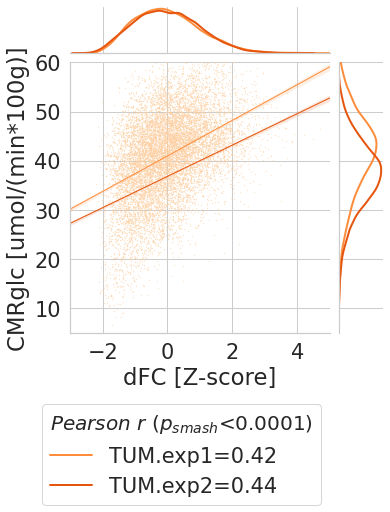

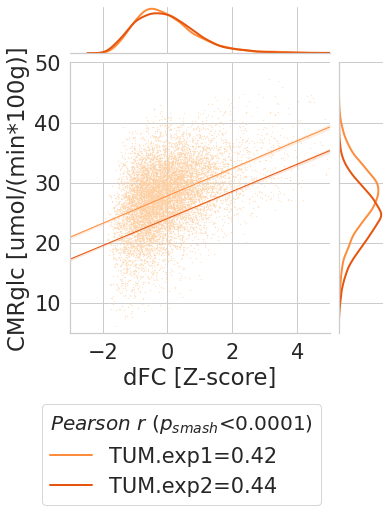

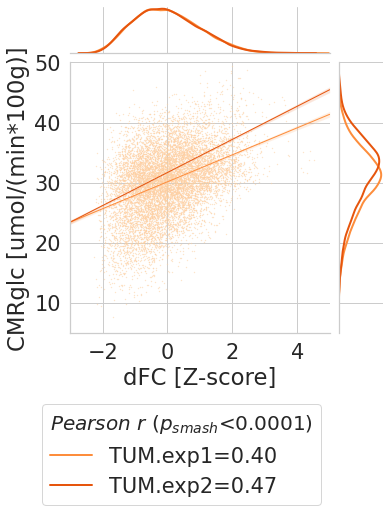

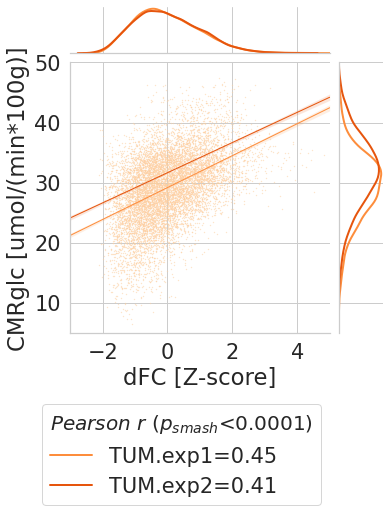

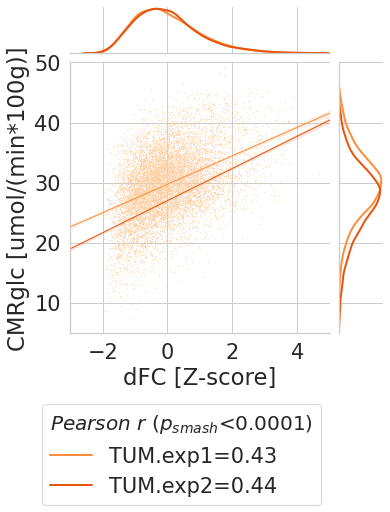

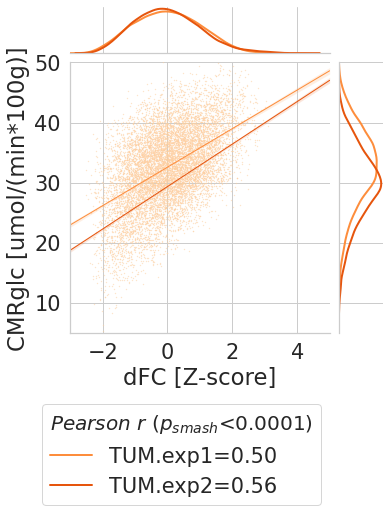

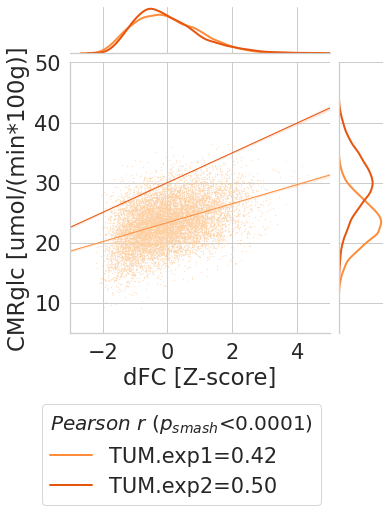

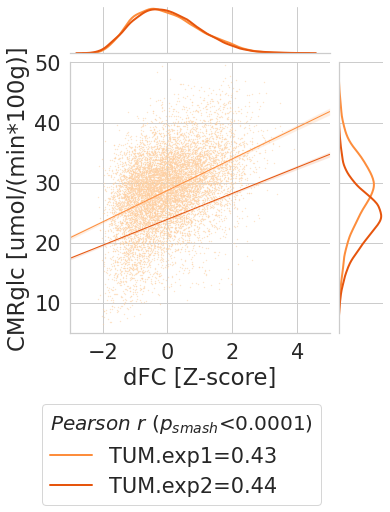

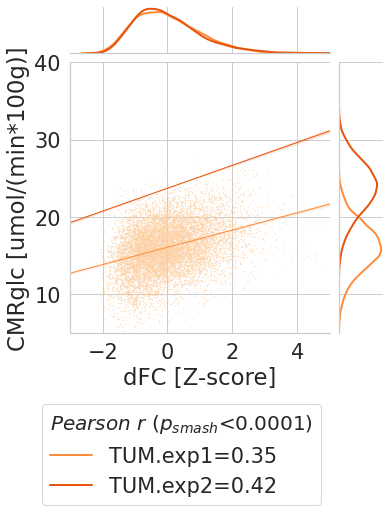

In [8]:
selected_df = all_ind_vox_vals
s = 0.1
selected_site = 'TUM' #options: TUM or VIE
coh0 = 'exp1' #options: exp1 or rep, if the latter (replication cohort TUM), it will ignore the coh1 variable
coh1 = 'exp2' #options: exp2
#selected_site_sids = list(np.unique(cohorts_metadata[selected_site][coh0]['sids']))
s1 = f'{selected_site}.{coh0}'
s2 = f'{selected_site}.{coh1}'
scatter_color = plt.cm.tab20c([7]).flatten() if selected_site=='TUM' else plt.cm.tab20c([11]).flatten()#
if((selected_site=='TUM') & (coh0=='rep')):
    scatter_color = plt.cm.tab20c([14]).flatten()
    selected_site_sids = cohorts_metadata[selected_site]['rep']['sids']
else:
    #selected_site_sids += list(np.unique(cohorts_metadata[selected_site][coh1]['sids']))
    selected_site_sids = list(np.unique(cohorts_metadata[selected_site][coh0]['sids']+cohorts_metadata[selected_site][coh1]['sids']))
for sid in selected_site_sids:#list(cohorts_metadata[selected_site]['a1']['sids']):
    subj_id = cohorts_metadata[selected_site][coh0]['sub_pref'] % sid
    ylim=(5,50) if sid not in [3,26,33] else (5,60)
    if sid in [26,28,31,34,36]: ylim=(5,40)
    if ((selected_site=='VIE') & (sid not in [4,9,12,14])): ylim=(10,65)
    selected_coh = s1 if sid in cohorts_metadata[selected_site][coh0]['sids'] else s2
    filtered_index = [((selected_df.cohort==selected_coh) & (selected_df.sid==subj_id))]
    smash_dists = [cohorts_metadata[selected_site][selected_coh.split('.')[1]]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
    cohorts_list = [s1,s2]
    color_list = [cohorts_metadata[selected_site][coh0]['color'],cohorts_metadata[selected_site][coh1]['color']]
    if((sid in cohorts_metadata[selected_site][coh1]['sids']) & (sid in cohorts_metadata[selected_site][coh0]['sids'])):
        filtered_index+=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists+=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list,color_list,scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.15,-0.675),plot_legend=True,s=s,ps_legend_flag=True)
    elif(sid in cohorts_metadata[selected_site][coh1]['sids']):
        filtered_index=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[1:],color_list[1:],scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.15,-0.675),plot_legend=True,s=s,ps_legend_flag=True)
    else:
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[:1],color_list[:1],scatter_color,
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.15,-0.675),plot_legend=True,s=s,ps_legend_flag=True)
 

Pearson's r range = 0.17150290920371278 - 0.5753348176793907; mean = 0.42; s.d. = 0.08; F(1,28) = 2.41, p = 0.13, one-way ANOVA
Slope range = 1.116846373151956 - 3.790573712608377; mean = 2.42; s.d. = 0.69; F(1,28) = 0.07, p = 0.79, one-way ANOVA
Pearson's r female / male: mean = 0.44 / 0.41, s.d. = 0.10 / 0.05; F(1,28) = 0.82, p = 0.37, one-way ANOVA
The model fit is independent of age (r = 0.07; p = 0.73; CI: [-0.30, 0.42])


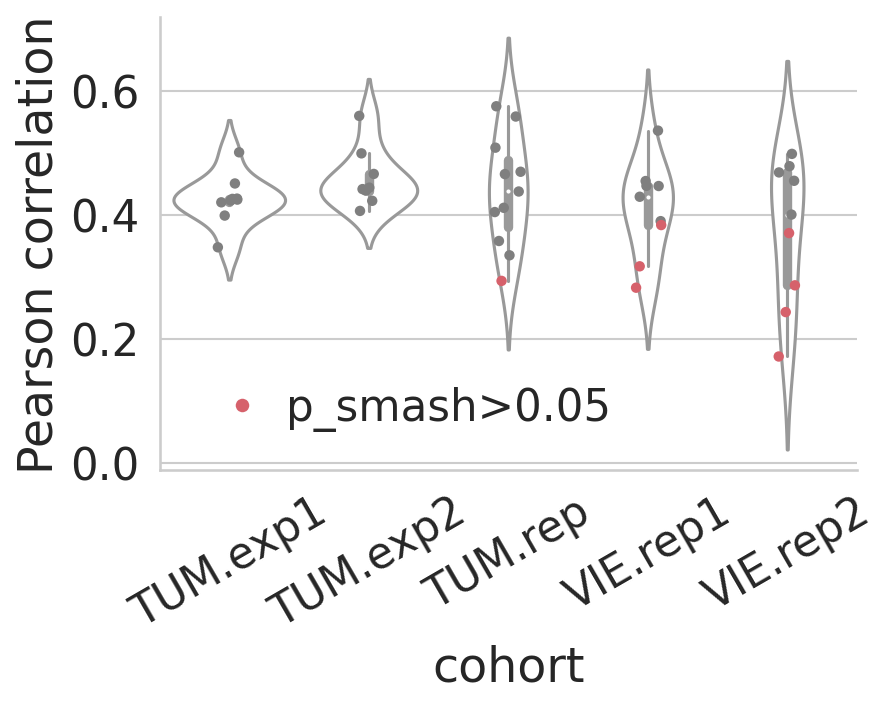

In [9]:
if 'reg_ind_lev_df' not in locals():
    reg_ind_lev_df = pd.DataFrame({},columns=['sid','sex','age','cohort', 'r', 'p', 'p_smash', 'variance','slope'])
    for site in list(cohorts_metadata.keys())[:-1]:
        for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
            cohort = f'{site}.{coh}'
            for sid in cohorts_metadata[site][coh]['sids']:
                subj_id = cohorts_metadata[site][coh]['sub_pref'] % sid
                ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==subj_id) & (all_ind_vox_vals.cohort==cohort)]
                ind_reg_dict = pg.linear_regression(ind_vox_vals[x_var],ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)
                p_ind_smash = nonparp(np.sqrt(ind_reg_dict['r2']), cohorts_metadata[site][coh]['individual_smash'][sid][f'smash_{x_var}-{y_var}'])
                p_ind_smash = p_ind_smash if p_ind_smash>0 else 0.0001
                reg_ind_lev_df = reg_ind_lev_df.append({'sid': subj_id,'cohort':cohort, 'r':np.sqrt(ind_reg_dict['r2']), 'p':ind_reg_dict['pval'][1].astype(float), 'p_smash':p_ind_smash, 'variance':ind_reg_dict['r2'].astype(float), 'slope':ind_reg_dict['coef'][1]}, ignore_index=True)

reg_ind_lev_df['variance'] = reg_ind_lev_df['variance'].astype('float')
            
reg_ind_lev_df['sex'] = reg_ind_lev_df['sid'].map(sex_participants_mapping)
reg_ind_lev_df['age'] = reg_ind_lev_df['sid'].map(age_participants_mapping)
reg_ind_lev_df['r']=reg_ind_lev_df['r'].astype('float')
reg_ind_lev_df['slope']=reg_ind_lev_df['slope'].astype('float')
    
cohort_order = ['TUM.exp1','TUM.exp2','TUM.rep','VIE.rep1','VIE.rep2']   
plt.figure(dpi=fig_res_dpi)
sns.violinplot(x="cohort", y="r",order=cohort_order,#dodge=False,
            data=reg_ind_lev_df,color="1",legend=False)
sns.stripplot(x="cohort",y="r", data=reg_ind_lev_df,jitter=True,dodge=True,color='k',order=cohort_order)#,linewidth=1)#,edgecolor='r',linewidth=1
ax1=plt.gca()
ax1.set(ylabel='Pearson correlation')#, color=sns.color_palette()[0])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)#
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
c_idx0=10 #derived from the ax1.collections: colls = [] for coll in ax1.collections: colls+=[coll.get_facecolor()];sns.palplot(coll.get_facecolor())
for coh in cohort_order:
    coh_face_colors = np.repeat(plt.cm.tab20([14]),reg_ind_lev_df[reg_ind_lev_df.cohort==coh].shape[0],axis=0)
    coh_face_colors[(reg_ind_lev_df[reg_ind_lev_df.cohort==coh].p_smash>0.055).to_numpy(dtype=bool),:] = plt.cm.tab20b([14])
    ax1.collections[c_idx0].set_facecolor(coh_face_colors)
    c_idx0+=1

from matplotlib.lines import Line2D
ax1.legend(handles=[Line2D([0], [0], marker='o', color='w', label='p_smash>0.05',markerfacecolor=plt.cm.tab20b([14]).flatten(), markersize=8, markeredgewidth=1.5)],
           loc='lower left', frameon=False, handletextpad=0.01)#, markeredgecolor='r'

## STATS
ind_stats = reg_ind_lev_df.describe().reset_index()
reg_mean_ind_lev_df = reg_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median()
reg_mean_ind_lev_df['cohort'] = reg_mean_ind_lev_df.cohort.str.split('.').str[0]
reg_mean_ind_lev_df = reg_mean_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median()
r_ind_diff_bet_cohorts = pg.anova(data=reg_mean_ind_lev_df,dv='r', between=['cohort'])
print(f'Pearson\'s r range = {" - ".join(str(val) for val in ind_stats.loc[ind_stats["index"].isin(["min","max"]),"r"].to_list())}; mean = {ind_stats.loc[ind_stats["index"]=="mean","r"].item():.2f}; s.d. = {ind_stats.loc[ind_stats["index"]=="std","r"].item():.2f}; F({r_ind_diff_bet_cohorts["ddof1"].item()},{r_ind_diff_bet_cohorts["ddof2"].item()}) = {r_ind_diff_bet_cohorts["F"].item():.2f}, p = {r_ind_diff_bet_cohorts["p-unc"].item():.2f}, one-way ANOVA')

#slope
slope_ind_diff_bet_cohorts = pg.anova(data=reg_mean_ind_lev_df,dv='slope', between=['cohort'])
print(f'Slope range = {" - ".join(str(val) for val in ind_stats.loc[ind_stats["index"].isin(["min","max"]),"slope"].to_list())}; mean = {ind_stats.loc[ind_stats["index"]=="mean","slope"].item():.2f}; s.d. = {ind_stats.loc[ind_stats["index"]=="std","slope"].item():.2f}; F({slope_ind_diff_bet_cohorts["ddof1"].item()},{slope_ind_diff_bet_cohorts["ddof2"].item()}) = {slope_ind_diff_bet_cohorts["F"].item():.2f}, p = {slope_ind_diff_bet_cohorts["p-unc"].item():.2f}, one-way ANOVA')


r_ind_diff_bet_sex = pg.anova(data=reg_mean_ind_lev_df,dv='r', between=['sex'])
F_ind_stats = reg_mean_ind_lev_df[reg_mean_ind_lev_df.sex=='F'].describe().reset_index()
M_ind_stats = reg_mean_ind_lev_df[reg_mean_ind_lev_df.sex=='M'].describe().reset_index()
print(f'Pearson\'s r female / male: mean = {F_ind_stats.loc[ind_stats["index"]=="mean","r"].item():.2f} / {M_ind_stats.loc[ind_stats["index"]=="mean","r"].item():.2f}, s.d. = {F_ind_stats.loc[ind_stats["index"]=="std","r"].item():.2f} / {M_ind_stats.loc[ind_stats["index"]=="std","r"].item():.2f}; F({r_ind_diff_bet_sex["ddof1"].item()},{r_ind_diff_bet_sex["ddof2"].item()}) = {r_ind_diff_bet_sex["F"].item():.2f}, p = {r_ind_diff_bet_sex["p-unc"].item():.2f}, one-way ANOVA')


corr_ed_age = pg.corr(reg_mean_ind_lev_df['r'].to_numpy(),
                      reg_mean_ind_lev_df['age'].to_numpy()).reset_index()
print(f'The model fit is independent of age (r = {corr_ed_age["r"].item():.2f}; p = {corr_ed_age["p-val"].item():.2f}; CI: [{corr_ed_age["CI95%"].item()[0]:.2f}, {corr_ed_age["CI95%"].item()[1]:.2f}])') 


### Figure 2. Energy density distribution
#### 2A. Calculation

names          coef        se             T  pval   r2   adj_r2  \
0  Intercept -9.887497e-15  0.565744 -1.747698e-14   1.0  0.0 -0.00012   
1         x1  4.151130e-16  0.018568  2.235676e-14   1.0  0.0 -0.00012   

   CI[5.0%]  CI[95.0%]  
0 -0.930670   0.930670  
1 -0.030545   0.030545

<Figure size 900x600 with 0 Axes>

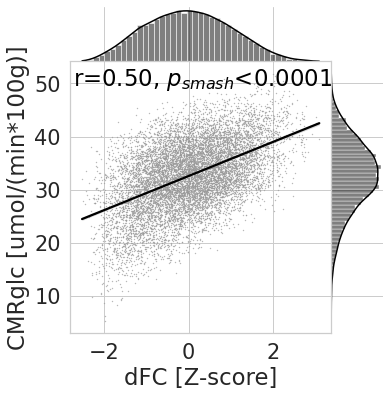

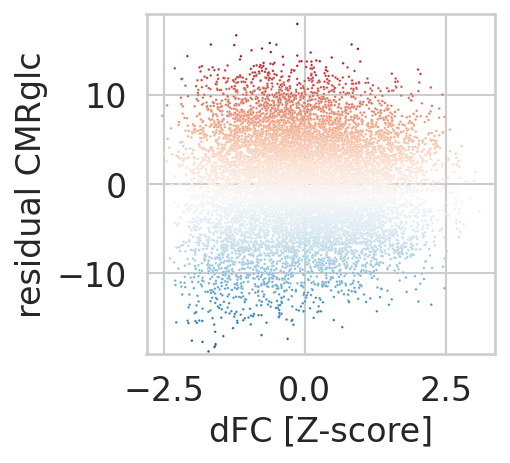

<Figure size 900x600 with 0 Axes>

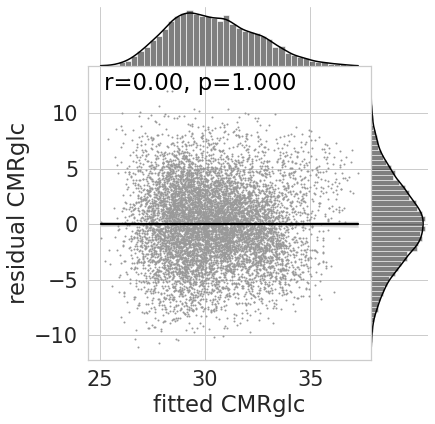

In [10]:
## Individual example
plt.figure(dpi=fig_res_dpi)
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)
#plt.suptitle(f'{cohorts_metadata[reference_site][reference_cohort]["sub_pref"] % example_sid} {reference_site}.{reference_cohort}')

plt.figure(figsize=(3,3),dpi=fig_res_dpi)
example_ind_vox_vals['residual'] = pg.linear_regression(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)['residuals']
sns.scatterplot(x_var,'residual',data=example_ind_vox_vals,s=15*s,legend=False,hue='residual', palette=sel_cm,
                vmin=example_ind_vox_vals.residual.quantile(0.3),vmax=example_ind_vox_vals.residual.quantile(0.7))
#plt.gca().set(xlabel=xlabel,ylabel='residual',ylim=(-19,19))
plt.xlabel(xlabel, fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('residual CMRglc', fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((-19,19))

## Average voxel values across subjects from all cohorts using a common group GM mask
avg_vox_vals_with_gx_mask = all_avg_vox_vals_with_gx_mask.groupby('vox_id',as_index=False).median()
avg_vox_vals_with_gx_mask_reg = pg.linear_regression(avg_vox_vals_with_gx_mask[x_var],avg_vox_vals_with_gx_mask[y_var],coef_only=False,remove_na=True,as_dataframe=False)
plt.figure(dpi=fig_res_dpi)
src.functions.plot_joint(avg_vox_vals_with_gx_mask_reg['pred'],avg_vox_vals_with_gx_mask_reg['residuals'],s=10*s,robust=False,
                         kdeplot=False,truncate=True,xlim0=False,x_label='fitted CMRglc',y_label='residual CMRglc')
pg.linear_regression(avg_vox_vals_with_gx_mask_reg['pred'],avg_vox_vals_with_gx_mask_reg['residuals'],coef_only=False,remove_na=True,alpha=0.1)


#### 2B. Stability

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 164, 165, 166, 172]
Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 164, 165, 166, 172]
Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 164, 165, 166, 172]
Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]
Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]


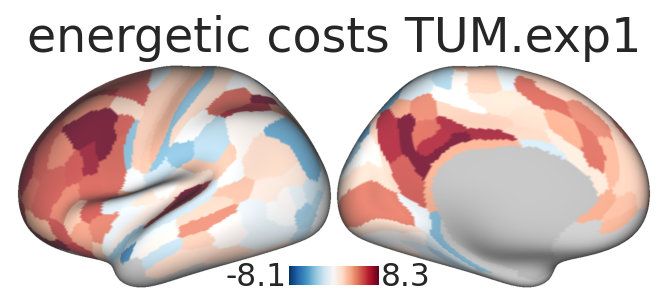

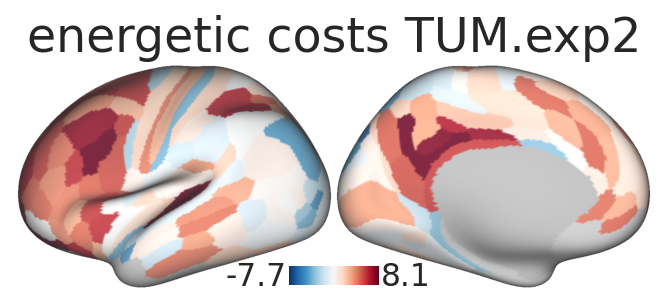

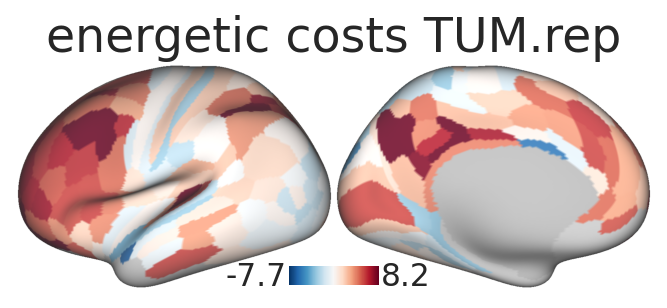

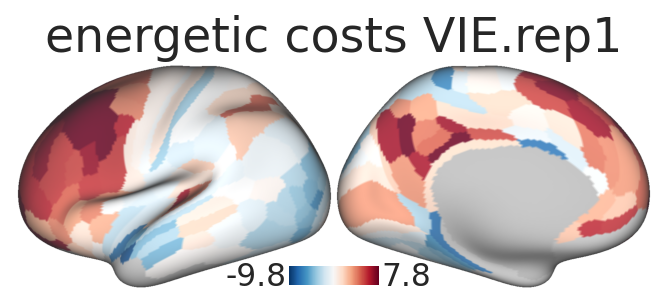

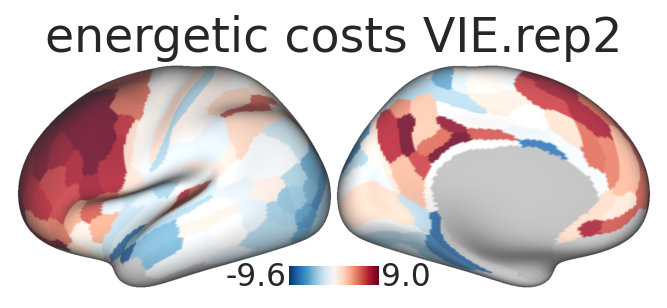

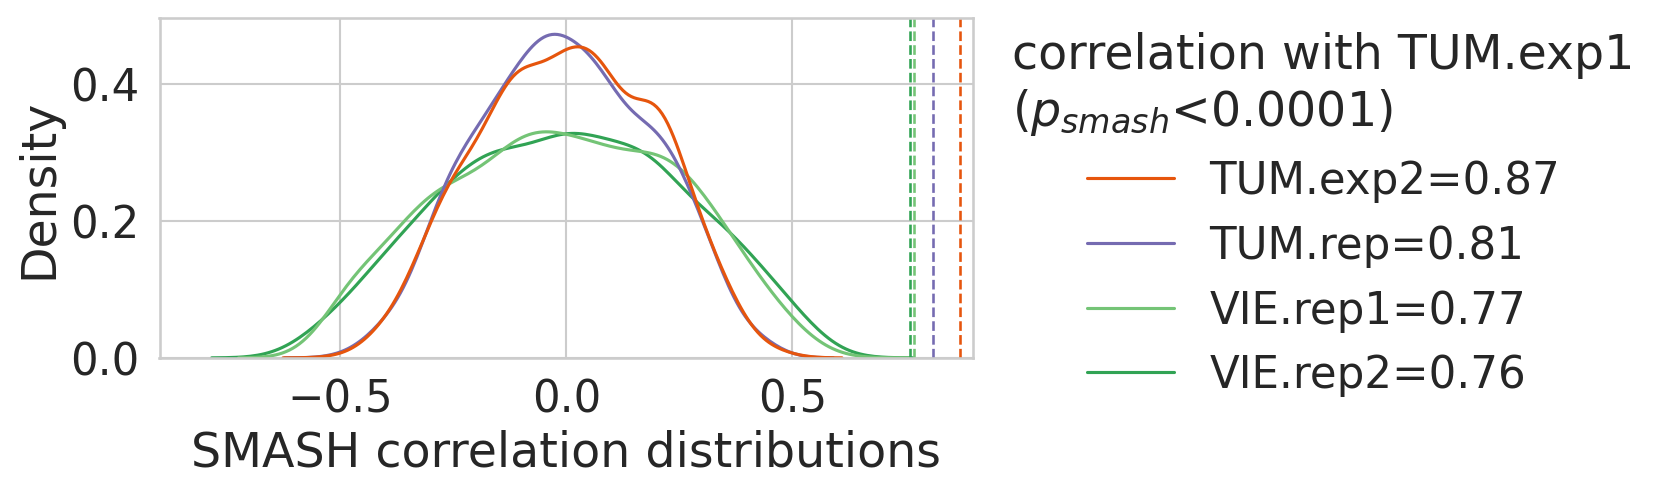

In [11]:
src.functions.plot_surf(src.functions.metric2mmp(all_avg_vox_vals[all_avg_vox_vals.cohort==f'{reference_site}.{reference_cohort}'],'energetic_costs','roi_id'),os.path.join(results_dir,'figures',f'fig2A_surf-ecosts_{reference_site}.{reference_cohort}'),
                        cmap=ListedColormap(extended_cm),show_colorbar=True,vlow=5,vhigh=95,fig_title=f'energetic costs {reference_site}.{reference_cohort}',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)
sd_smash_corr_bet_coh_df = pd.DataFrame({})
sd_smash_corr_bet_coh_palette = {}
for cohort in cohort_order[1:]:
    r_param,p_param=stats.pearsonr(all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==f'{reference_site}.{reference_cohort}','energetic_costs'],
                                   all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==cohort,'energetic_costs'])
    sd_smash_corr_bet_coh_df[f'{cohort}={r_param:.2f}'] = cohorts_metadata['all'][f'smash_ecosts_{reference_site}.{reference_cohort}-{cohort}']
    sd_smash_corr_bet_coh_palette[f'{cohort}={r_param:.2f}'] = cohorts_metadata[cohort.split('.')[0]][cohort.split('.')[1]]['color']
    src.functions.plot_surf(src.functions.metric2mmp(all_avg_vox_vals[all_avg_vox_vals.cohort==cohort],'energetic_costs','roi_id'),os.path.join(results_dir,'figures',f'fig2B_surf_ecosts-{cohort}'),
                            cmap=ListedColormap(extended_cm),show_colorbar=True,vlow=5,vhigh=95,fig_title=f'energetic costs {cohort}',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)
    
plt.figure(figsize=(7,3),dpi=fig_res_dpi)
g = sns.kdeplot(data=sd_smash_corr_bet_coh_df,palette=sd_smash_corr_bet_coh_palette,legend=True)
legend_handles = g.get_legend().legendHandles #get_legend_handles_labels()
g.get_legend().remove()
plt.legend(handles=legend_handles,title='correlation with TUM.exp1\n'+r'$(p_{smash}$<0.0001)', loc='upper left',ncol=1,bbox_to_anchor=(1,1.075), labels=list(sd_smash_corr_bet_coh_df.columns),frameon=False)#(-0.35,-0.3)
plt.gca().set_xlim(-0.9,0.9)
plt.gca().set_xlabel('SMASH correlation distributions')
for ix,col in enumerate(list(sd_smash_corr_bet_coh_df.columns)):
    plt.gca().axvline(float(col.split('=')[1]), 0, 1, color=sd_smash_corr_bet_coh_palette[col], linestyle='dashed', lw=1.25)


#### 2C. Group statistics

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]
Missing ROIs: [88, 90, 92, 93, 95, 110, 118, 120, 122, 131, 135, 164, 165, 166, 172]


<Figure size 900x600 with 0 Axes>

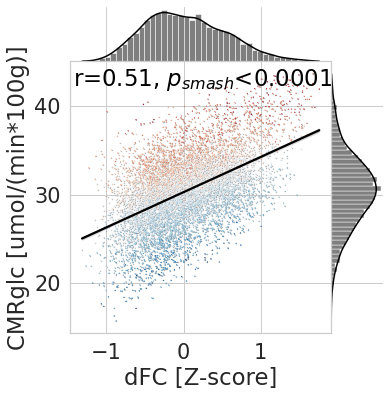

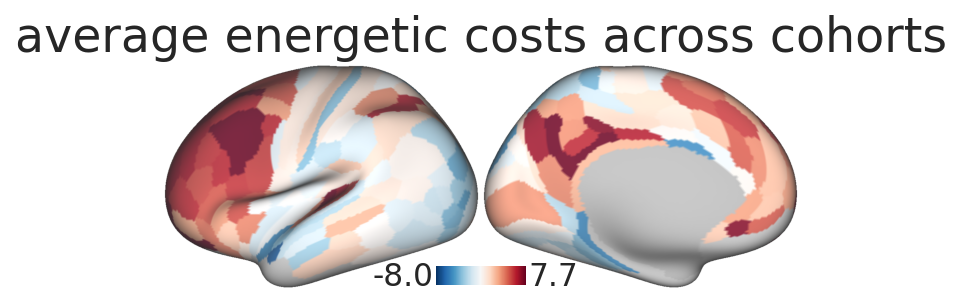

<Figure size 900x600 with 0 Axes>

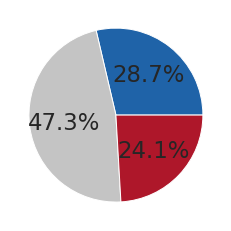

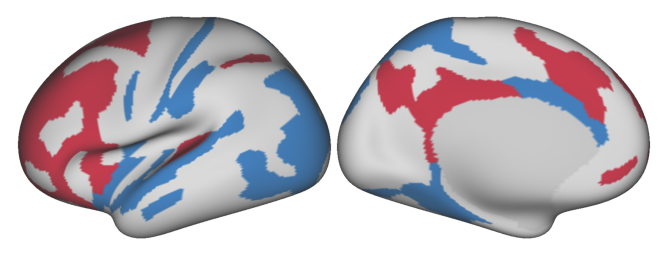

In [12]:
##NOT: generate first avg_vox_vals_with_gx_mask df in Fig. 2A
## Group linear relationship color coded by energy density 
r_vox_param_all,_=stats.pearsonr(avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),x_var],
                                 avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),y_var])
p_vox_np_all = nonparp(r_vox_param_all, cohorts_metadata['all']['smash_{}-{}'.format(x_var,y_var)])
p_vox_np_all = p_vox_np_all if p_vox_np_all>0 else 0.00001

plt.figure(dpi=fig_res_dpi)
g = src.functions.plot_joint(avg_vox_vals_with_gx_mask[x_var],avg_vox_vals_with_gx_mask[y_var],s=0.1,robust=False,kdeplot=False,truncate=True,
               xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np_all)
sns.scatterplot(x=x_var, y=y_var, hue='energetic_costs',data=avg_vox_vals_with_gx_mask,
                linewidth=0,s=1.5,legend=False,palette=sel_cm,ax=g.ax_joint,
                vmin=avg_vox_vals_with_gx_mask.energetic_costs.quantile(0.25),vmax=avg_vox_vals_with_gx_mask.energetic_costs.quantile(0.75))

## Average ROI values across subjects from all cohorts for visualization purposes and comparisson with external data
avg_roi_ed_vals= src.functions.metric2mmp(all_avg_roi_vals,'energetic_costs','roi_id')
src.functions.plot_surf(avg_roi_ed_vals,os.path.join(results_dir,'figures',f'fig2C_surf_ecosts-avg'),cmap=ListedColormap(extended_cm),
                        show_colorbar=True,vlow=5,vhigh=95,fig_title='average energetic costs across cohorts',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)



## Voxelwise one sample t-test statistics across subjects
gx_gm_mask_fn = os.path.join(root_dir,'gx_between-cohort_gm-mask_25perc_mni-3mm.nii.gz')
if not os.path.exists(gx_gm_mask_fn):
    !wget https://openneuro.org/crn/datasets/ds004513/files/derivatives:energetic-costs:gx_between-cohort_gm-mask_25perc_mni-3mm.nii.gz -O {gx_gm_mask_fn}
all_sd_fn = os.path.join(root_dir,'all_47subj_ed-z_one-sample-t-test_vox_corrp_tstat1_lt_0.01_mni-3mm.nii.gz')
if not os.path.exists(all_sd_fn):
    !wget https://openneuro.org/crn/datasets/ds004513/files/derivatives:energetic-costs:all_47subj_ed-z_one-sample-t-test_vox_corrp_tstat1_lt_0.01_mni-3mm.nii.gz -O {all_sd_fn}

avg_vox_vals_with_gx_mask['ostt_mask'] = input_data.NiftiMasker(mask_img=gx_gm_mask_fn).fit_transform(all_sd_fn).flatten()[avg_vox_vals_with_gx_mask.vox_id.to_numpy()]
avg_vox_vals_with_gx_mask['ostt_signed'] = avg_vox_vals_with_gx_mask['ostt_mask'] 
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energetic_costs']<0),'ostt_signed'] = -1
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energetic_costs']>0),'ostt_signed'] = 1

one_sample_ttest_roi_df = avg_vox_vals_with_gx_mask[['roi_id','ostt_signed']].groupby('roi_id',as_index=False).agg(lambda x: stats.mode(x)[0][0])
one_sample_ttest_roi_df['ostt_mask'] = one_sample_ttest_roi_df['ostt_signed']
one_sample_ttest_roi_df.loc[one_sample_ttest_roi_df['ostt_mask']!=0,'ostt_mask']=1
#src.functions.plot_surf(src.functions.metric2mmp(one_sample_ttest_roi_df,'ostt_mask','roi_id',median=False),os.path.join(results_dir,'figures',f'fig2C_surf_ostt_mask'),
#                        cmap=ListedColormap([gray_c,plt.cm.Set2([5]).flatten()]),show_colorbar=False,generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)
plt.figure(dpi=fig_res_dpi)
one_sample_ttest_roi_df.groupby('ostt_signed').count().plot(kind='pie', y='roi_id',legend=False,colors=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0),shadow=False,autopct='%1.1f%%',xlabel='',ylabel='',labels=['','',''],startangle=0)
src.functions.plot_surf(src.functions.metric2mmp(one_sample_ttest_roi_df,'ostt_signed','roi_id',median=False),os.path.join(results_dir,'figures',f'fig2C_surf_ostt_signed_mask'),
                        cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0)),show_colorbar=False,generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)



#### 2D. Subject and network distribution

NOTE: this cells needs longer time to run due to the strip-plot. You can skip it without having dependency problems with other cells below.

<Figure size 900x600 with 0 Axes>

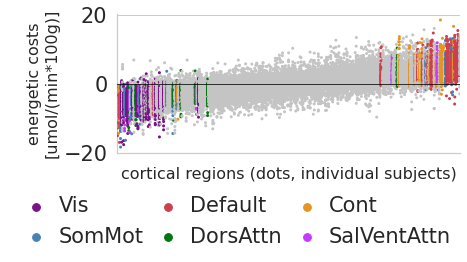

<Figure size 900x600 with 0 Axes>

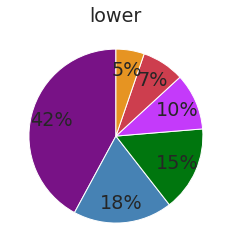

<Figure size 900x600 with 0 Axes>

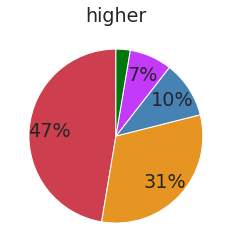

In [14]:
all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()
all_ind_roi_vals['nw'] = all_ind_roi_vals['roi_id'].map(atlas_dict['roi2network'])
all_ind_roi_vals['nw_consistent_rois'] = all_ind_roi_vals['nw']
all_ind_roi_vals['ecosts_sign_consistent_rois'] = 0
for roi_id in all_ind_roi_vals.roi_id.unique():
    if np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energetic_costs'].to_numpy()>0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ecosts_sign_consistent_rois'] = -1
    elif np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energetic_costs'].to_numpy()<0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ecosts_sign_consistent_rois'] = 1
    else:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'nw_consistent_rois'] = 'None'

nw_consistent_rois_palette = atlas_dict['nw2color']
nw_consistent_rois_palette['None'] = gray_c

roi_ids_order = all_ind_roi_vals[all_ind_roi_vals.roi_id.isin(all_ind_roi_vals.roi_id.unique())].groupby('roi_id',as_index=False).median().sort_values(by='energetic_costs',ignore_index=True).roi_id.to_list()
plt.figure(dpi=fig_res_dpi)
g = sns.catplot(x='roi_id', y='energetic_costs', data=all_ind_roi_vals[all_ind_roi_vals.roi_id.isin(all_ind_roi_vals.roi_id.unique())],height=3.5,aspect=2,hue='nw_consistent_rois',
                palette=nw_consistent_rois_palette,order=roi_ids_order,legend=True,s=3)
rcparams_titlepad = plt.rcParams['axes.titlepad']
plt.rcParams['axes.titlepad'] = -14
g.set(xticklabels=[])
plt.gca().set_xlabel('cortical regions (dots, individual subjects)',fontsize=16)
plt.gca().set_ylabel('energetic costs\n[umol/(min*100g)]',fontsize=16)
plt.rcParams['axes.titlepad'] = rcparams_titlepad
plt.gca().axhline(0, 0, 1, color='k', lw=0.75,zorder=10)
h,l = plt.gca().get_legend_handles_labels()
g._legend.remove()
plt.legend(h[1:],l[1:],loc='lower left', ncol=3, bbox_to_anchor=(-0.35, -0.8),frameon=False, columnspacing=0.2,handletextpad=0.05)
##F
def autopct(pct): # only show the label when it's > 10%
    return ('%d%%' % pct) if pct > 4 else ''
sns.set_context("notebook", font_scale=1.6)
avg_consistent_roi_vals = all_ind_roi_vals[all_ind_roi_vals.nw_consistent_rois!='None']
plt.figure(dpi=fig_res_dpi)
avg_consistent_neg_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ecosts_sign_consistent_rois<0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_neg_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,xlabel='',ylabel='',startangle=90,title='lower',pctdistance=0.77,autopct=autopct,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_neg_roi_vals.index.tolist()])
plt.figure(dpi=fig_res_dpi)
avg_consistent_pos_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ecosts_sign_consistent_rois>0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_pos_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,xlabel='',ylabel='',startangle=90,title='higher',pctdistance=0.77,autopct=autopct,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_pos_roi_vals.index.tolist()])
sns.set_context("notebook", font_scale=1.9)

### Figure 3. Energy density distribution relates to human cognitive functions and cortical evolution
#### 3A. Evolutionary allometry of total brain metabolism

names      coef        se         T      pval        r2    adj_r2  \
0    Intercept -0.089278  0.042996 -2.076428  0.071511  0.810295  0.786582   
1  log(volume) -0.141742  0.024248 -5.845578  0.000385  0.810295  0.786582   

   CI[5.0%]  CI[95.0%]  
0 -0.169231  -0.009325  
1 -0.186832  -0.096652

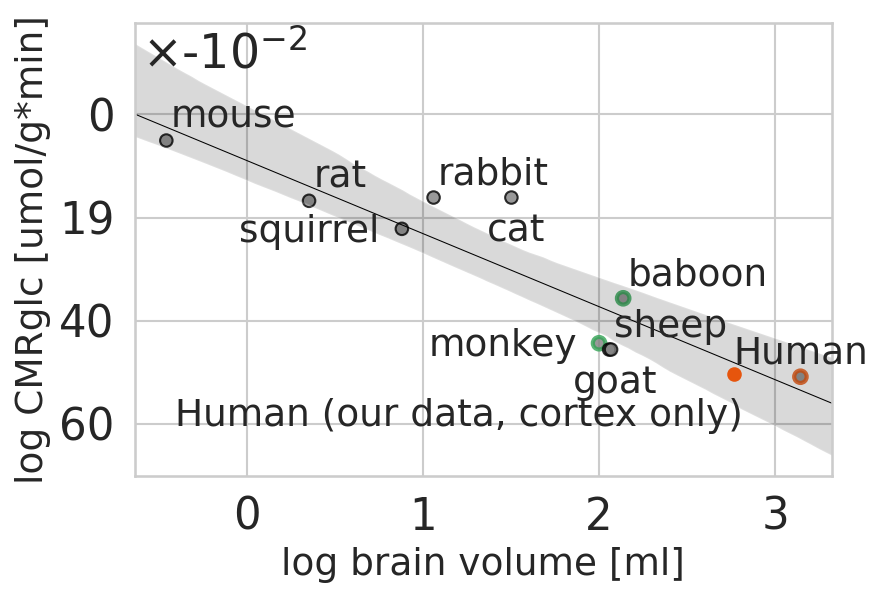

In [15]:
## Karbowski J. BMC Biology 2007
total_glucose = {'mouse':0.32,'rat':1.52,'squirrel':3.88,'rabbit':7.93,'cat':21.78,'monkey':35.98,'sheep':40.18,'goat':40.09,'baboon':60.40,'Human':428.55,# (Karbowski 2007, whole brain)
                }
total_volume = {'mouse':0.35,'rat':2.26,'squirrel':7.6,'rabbit':11.5,'cat':31.8,'monkey':100,'sheep':114,'goat':117,'baboon':137,'Human':1389,# (Karbowski 2007, whole brain)
               }
scatter_border_colors = ['k' for ix in range(len(total_glucose)-1)] + [plt.cm.tab20c(range(20))[4]]
scatter_border_widths = [1 for ix in range(len(total_glucose)-1)] + [2]
scatter_border_colors[5] = plt.cm.tab20c(range(20))[8]
scatter_border_colors[8] = plt.cm.tab20c(range(20))[8]
scatter_border_widths[5] = 2
scatter_border_widths[8] = 2
allometric_Karbowski_df = pd.DataFrame(total_volume, index=[0]).melt(var_name='species',value_name='volume')
allometric_Karbowski_df['total_glucose'] = allometric_Karbowski_df['species'].map(total_glucose)
allometric_Karbowski_df['log(total_glucose)'] = np.log10(allometric_Karbowski_df['total_glucose'])
allometric_Karbowski_df['log(volume)'] = np.log10(allometric_Karbowski_df['volume'])
this_study_volume = 581
this_study_cmrglc = all_ind_vox_vals.groupby(['roi_id'],as_index=False).median()[pet_metric].mean()/100
cmrglc = {'mouse':0.89,'rat':0.68,'squirrel':0.6,'rabbit':0.69,'cat':0.69,'monkey':0.36,'sheep':0.35,'goat':0.35,'baboon':0.44,'Human':0.31}# (Karbowski 2007, whole brain)
allometric_Karbowski_df['cmrglc'] = allometric_Karbowski_df['species'].map(cmrglc)
allometric_Karbowski_df['log(cmrglc)'] = np.log10(allometric_Karbowski_df['cmrglc'])
##Plotting
plt.figure(dpi=fig_res_dpi)
sns.regplot(x='log(volume)',y='log(cmrglc)',data=allometric_Karbowski_df,truncate=False,scatter_kws={'color':'gray','edgecolors':scatter_border_colors,'linewidth':scatter_border_widths},line_kws={'color':'k','linewidth':0.5})
plt.gca().plot(np.log10(this_study_volume),np.log10(this_study_cmrglc),
               '.',color=plt.cm.tab20c(range(20))[4],markersize=12,label='Human (our data,cortex only)')
plt.xlabel('log brain volume [ml]',fontsize=18)
plt.ylabel('log CMRglc [umol/g*min]',fontsize=18)

linreg_cmrglc_Karbowski = pg.linear_regression(allometric_Karbowski_df['log(volume)'],allometric_Karbowski_df['log(cmrglc)'],coef_only=False,remove_na=True,alpha=0.1,as_dataframe=False)
allometric_cmrglc_model = 'Allometric relationship: '+r'$\it{CMRglc\ \propto\ brain\ volume^{%0.2f}}$' % (linreg_cmrglc_Karbowski['coef'][1])
#plt.gca().text(plt.gca().get_xlim()[0]-1,plt.gca().get_ylim()[0]-0.3, allometric_cmrglc_model, ha='left',va='top', color='k',fontsize=22)

for index, row in allometric_Karbowski_df.iterrows():
    if row['species'] in (['squirrel','monkey']):#,'baboon','goat','cat','Human (Karbowski 2007, whole brain)']):
        #plt.gca().annotate(row['species'], (row['log(volume)']-0.1, row['log(total_glucose)']),fontsize=10,ha = 'right')
        plt.gca().annotate(row['species'], (row['log(volume)']-0.125, row['log(cmrglc)']-0.025),fontsize=18, ha='right')
    elif row['species'] in (['goat','cat']):
        #plt.gca().annotate(row['species'], (row['log(volume)']+0.05, row['log(total_glucose)']-0.2),fontsize=14)
        plt.gca().annotate(row['species'], (row['log(volume)']+0.025, row['log(cmrglc)']-0.1),fontsize=18, ha='center', va="bottom")
    elif row['species']=='Human':
        plt.gca().annotate(row['species'], (row['log(volume)'], row['log(cmrglc)']+0.025),fontsize=18,ha='center')
    else:
        plt.gca().annotate(row['species'], (row['log(volume)']+0.025, row['log(cmrglc)']+0.025),fontsize=18)
plt.gca().annotate('Human (our data, cortex only)', (np.log10(this_study_volume)+0.05, (np.log10(this_study_cmrglc)-0.1)),fontsize=18,ha='right')

plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 10))
plt.gca().get_yaxis().get_offset_text().set_visible(False)
ay_max = max(plt.gca().get_yticks())
exponent_ayis = np.floor(np.log10(abs(ay_max))).astype(int)
ay_ticks= plt.gca().get_yticks()
plt.gca().set_yticklabels((-100*ay_ticks).astype(int))
plt.gca().annotate(r'$\times$-10$^{%i}$'%(2*exponent_ayis),
             xy=(.01, .9), xycoords='axes fraction')

pg.linear_regression(allometric_Karbowski_df['log(volume)'],allometric_Karbowski_df['log(cmrglc)'],coef_only=False,remove_na=True,alpha=0.1)


#### 3B. Regional evolution of brain metabolism

names      coef        se         T          pval        r2    adj_r2  \
0  Intercept -2.384172  0.441422 -5.401114  1.262651e-07  0.089957  0.087225   
1         x1  0.693228  0.120828  5.737331  2.162178e-08  0.089957  0.087225   

   CI[5.0%]  CI[95.0%]  
0 -3.112273  -1.656071  
1  0.493930   0.892526

<Figure size 900x600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

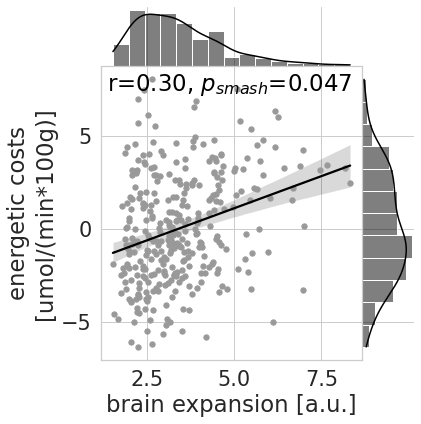

In [16]:
chimp2human_expansion = []
for _, h in enumerate(['lh', 'rh']):
    chimp2human_expansion = np.append(chimp2human_expansion, nib.load(os.path.join(root_dir,'external',f'Wei2019/{h}.32k.chimp2humanF.smoothed15.shape.gii')).darrays[0].data)
chimp2human_expansion = surface_to_parcel(chimp2human_expansion,'glasser_360_conte69')[1:]
avg_allrois_ed_vals = all_avg_roi_vals.groupby(['roi_id','nw'], as_index=False).median()
rois_available = avg_allrois_ed_vals.roi_id.to_numpy()-1
plt.figure(dpi=fig_res_dpi)
src.functions.smash_comp(chimp2human_expansion[rois_available],avg_allrois_ed_vals['energetic_costs'],None,y_nii_fn=os.path.join(results_dir,'figures',f'fig3C_ecosts-chimp2humanexpansion.png'),
           l=5,u=95,n_mad='min',ylabel='energetic costs\n[umol/(min*100g)]', xlabel='brain expansion [a.u.]',p_uthr=1,plot=True,
           cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=False,plot_surface=False,x_surr_corrs=cohorts_metadata['all'][f'smash_expansion_ecosts-{x_var}-{y_var}']
          )
pg.linear_regression(chimp2human_expansion[rois_available],avg_allrois_ed_vals['energetic_costs'],coef_only=False,remove_na=True,alpha=0.1)
sns.set_context("notebook", font_scale=2.1)
pg.linear_regression(chimp2human_expansion[rois_available],avg_allrois_ed_vals['energetic_costs'],coef_only=False,remove_na=True,alpha=0.1)


[comment]: <> (### Figure 4. Layer specific cellular organization of energy dense regions)
#### 3C. Cell density distribution across cortical layers

Text(0.01, 0.85, '$\\times$10$^{-4}$')

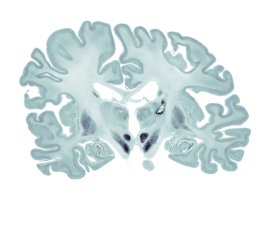

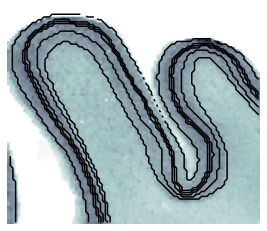

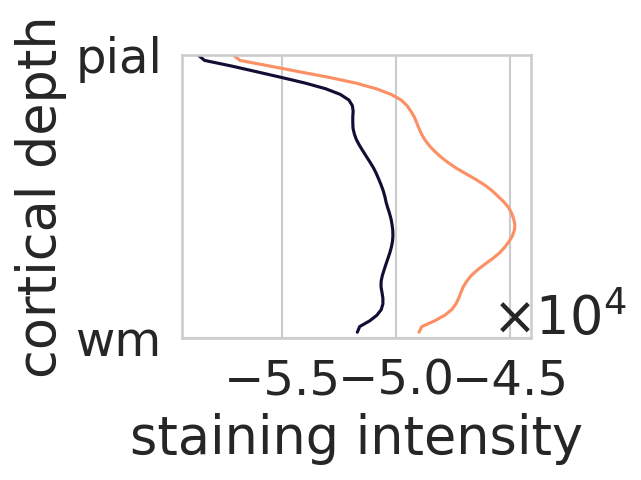

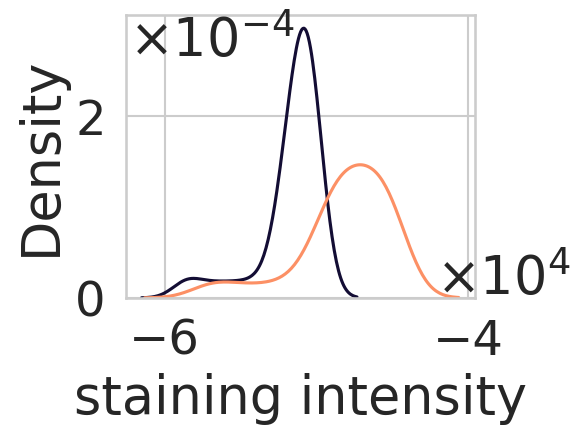

In [17]:
## Ultra-high resolution histological slice from the BigBrain atlas
bb_vol_fn = os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','full8_200um_optbal.nii.gz')
bb_layers_fn = os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','segmentation_200um.nii.gz')
if not os.path.exists(os .path.dirname(bb_vol_fn)):
    os.mkdir(os .path.dirname(bb_vol_fn))
    !wget -P {os .path.dirname(bb_vol_fn)} https://github.com/kwagstyl/cortical_layers_tutorial/raw/main/data/full8_200um_optbal.nii.gz
    !wget -P {os .path.dirname(bb_vol_fn)} https://github.com/kwagstyl/cortical_layers_tutorial/raw/main/data/segmentation_200um.nii.gz
bb_vol = nib.load(bb_vol_fn)
bb_layers = nib.load(bb_layers_fn)
section = 385 # seleceted arbitrarily
bb_layers_section=bb_layers.dataobj[section]
bb_histo_section = bb_vol.dataobj[section]
plt.imshow(np.flipud(bb_histo_section),cmap='bone')
plt.gca().axis('off')
plt.figure()
plt.imshow(np.flipud(bb_histo_section[480:560,297:390]),cmap='bone') # seleceted arbitrarily
plt.gca().axis('off')
bb_layers_section[bb_layers_section<1]=np.nan
bb_layers_section[np.isin(bb_layers_section,[2,3,5,6])]=np.nan
plt.gca().contour(np.flipud(bb_layers_section[480:560,297:390]), colors='k')

## Big brain upsample to 50 cortical layers between pial and white matter surfaces
bb_profiles = np.loadtxt(os.path.join(root_dir,'external','BigBrainWarp','tpl-fs_LR_den-32k_desc-profiles.txt'),delimiter=',')
bb_profiles_inv = bb_profiles * -1
bb_profiles_inv_all = surface_to_parcel(np.sum(bb_profiles_inv,axis=0),'glasser_360_conte69')[1:]
bbl_roi = np.array([])
for bb_layer in bb_profiles_inv:
    bbl_roi = np.append(bbl_roi,surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:],axis=0) if bbl_roi.shape[0]>0 else surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:]
bbl_roi_mean = np.mean(bbl_roi,axis=0)
bbl_roi_skew = []
for bbp in bbl_roi.T:
    bbl_roi_skew += [stats.skew(bbp, bias=True)]
bbl_roi_skew = np.array(bbl_roi_skew)

##example datapoints selected visually from the scatter plot
lskew = np.where((bbl_roi_skew[:180]>-2.25) & (bbl_roi_skew[:180]<-2.2) & (avg_roi_ed_vals>5))[0][0]
hskew=np.where((bbl_roi_skew[:180]<-1.38) & (bbl_roi_skew[:180]>-1.4) & (avg_roi_ed_vals<0) & (avg_roi_ed_vals>-0.3))[0][0]

plt.figure(figsize=(3,2.5),dpi=fig_res_dpi)
plt.plot(bbl_roi[:,lskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[24],label='left')
plt.plot(bbl_roi[:,hskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[196],label='right') #231
plt.gca().set(ylim=(0,50),yticks=(0,50),yticklabels=['wm','pial'],xlabel='staining intensity',ylabel='cortical depth')
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().get_xaxis().get_offset_text().set_visible(False)
ax_max = max(plt.gca().get_xticks())
exponent_axis = np.floor(np.log10(abs(ax_max))).astype(int)
plt.gca().annotate(r'$\times$10$^{%i}$'%(exponent_axis),xy=(.89, .01), xycoords='axes fraction')

plt.figure(figsize=(3,2.5),dpi=fig_res_dpi)
sns.kdeplot(bbl_roi[:,lskew],color=getattr(plt.cm,'magma')(range(256))[24],label='left')
sns.kdeplot(bbl_roi[:,hskew],color=getattr(plt.cm,'magma')(range(256))[196],label='right')#231
plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().set(xlabel='staining intensity')
plt.gca().get_xaxis().get_offset_text().set_visible(False)
ax_max = max(plt.gca().get_xticks())
exponent_axis = np.floor(np.log10(abs(ax_max))).astype(int)
plt.gca().annotate(r'$\times$10$^{%i}$'%(exponent_axis),
             xy=(.89, .01), xycoords='axes fraction')

plt.gca().get_yaxis().get_offset_text().set_visible(False)
ay_max = max(plt.gca().get_yticks())
exponent_ayis = np.floor(np.log10(abs(ay_max))).astype(int)
plt.gca().annotate(r'$\times$10$^{%i}$'%(exponent_ayis),
             xy=(.01, .85), xycoords='axes fraction')


***Energy density relationship with cell density in infragranular layers***

<Figure size 900x600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

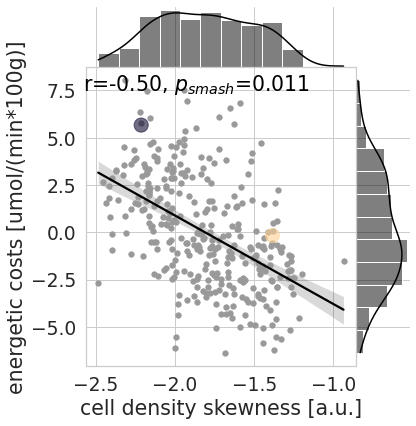

In [19]:
plt.figure(dpi=fig_res_dpi)
if f'smash_bb-skew_ecosts-{x_var}-{y_var}' not in cohorts_metadata['all'].keys():
    cohorts_metadata['all'][f'smash_bb-skew_ecosts-{x_var}-{y_var}'] = src.functions.smash_comp(bbl_roi_skew[:180],avg_roi_ed_vals,lh_dist_full,y_nii_fn=os.path.join(results_dir,'figures',f'fig3C_bb-skew_vs_ecosts.png'),
                                                                                                l=5,u=95,n_mad='min',p_uthr=1,plot=False)
sns.set_context("notebook", font_scale=1.7)
src.functions.smash_comp(bbl_roi_skew[rois_available],avg_allrois_ed_vals['energetic_costs'],None,y_nii_fn=os.path.join(results_dir,'figures',f'fig3C_bb-skew_vs_ecosts.png'),
                         ylabel='energetic costs [umol/(min*100g)]', xlabel='cell density skewness [a.u.]',
                         l=5,u=95,n_mad='min',p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False,
                         x_surr_corrs=cohorts_metadata['all'][f'smash_bb-skew_ecosts-{x_var}-{y_var}'])
plt.gca().scatter(bbl_roi_skew[[lskew,hskew]],avg_roi_ed_vals[[lskew,hskew]],s=200, alpha=0.6,
                  c=np.concatenate((getattr(plt.cm,'magma')(range(256))[24][np.newaxis,:],getattr(plt.cm,'magma')(range(256))[231][np.newaxis,:]),axis=0))

pg.linear_regression(bbl_roi_skew[rois_available],avg_allrois_ed_vals['energetic_costs'],coef_only=False,remove_na=True,alpha=0.1)
sns.set_context("notebook", font_scale=1.9)


### Figure 4. Higher rate of neuromodulation in energy dense regions
#### 4A. Genetic mapping

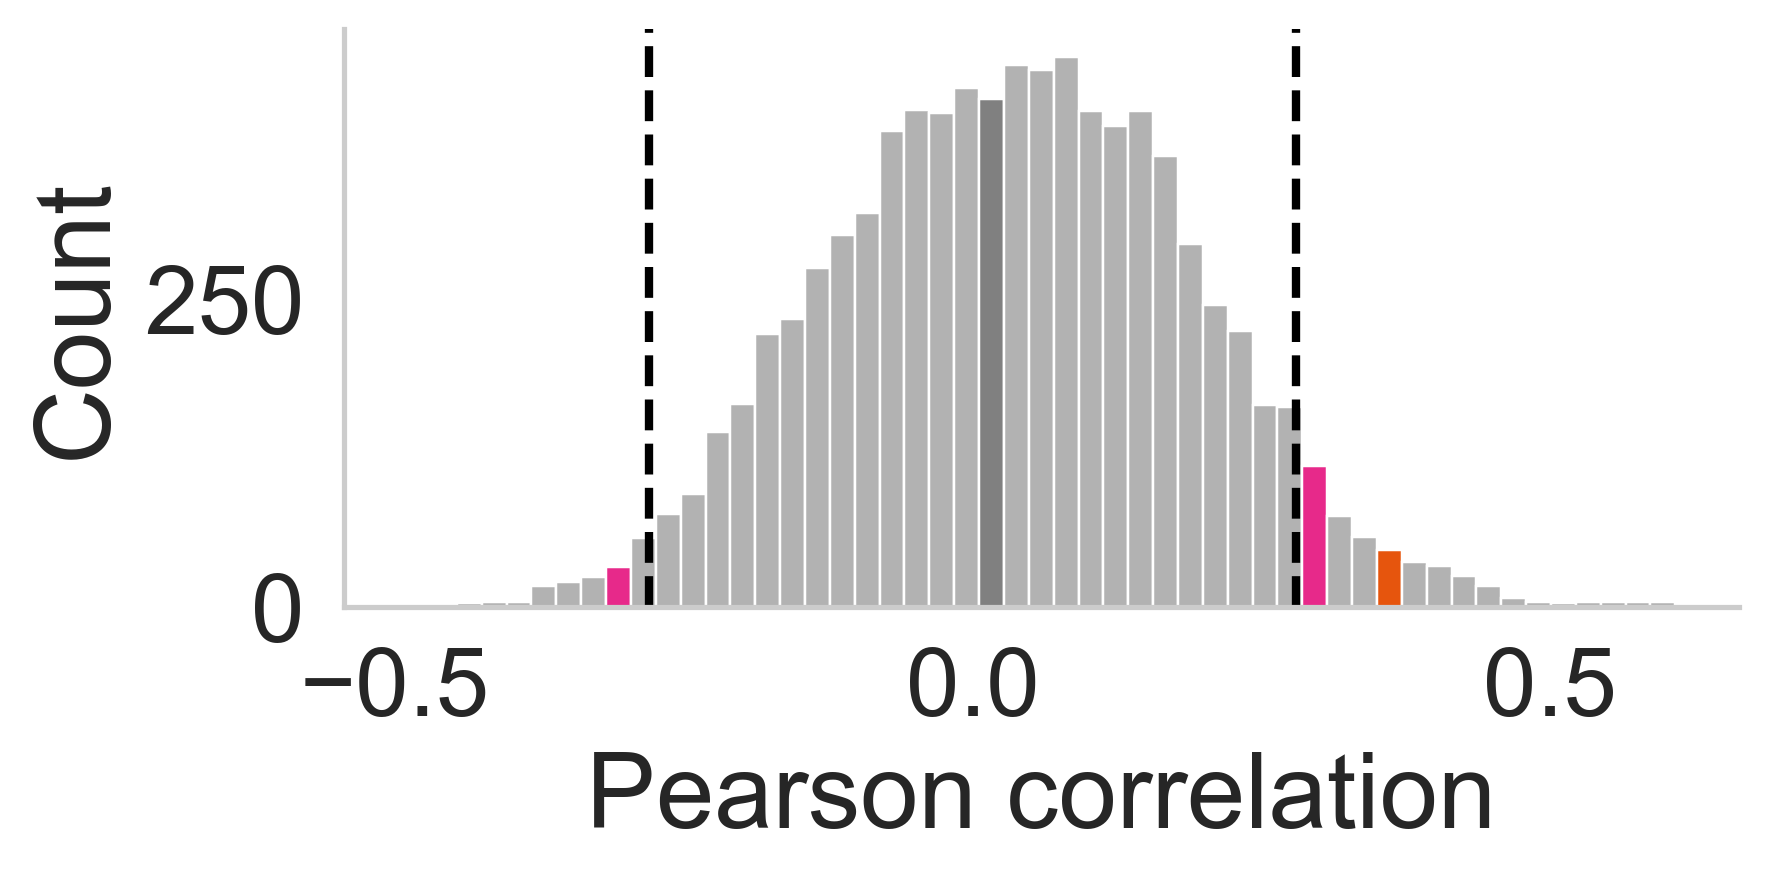

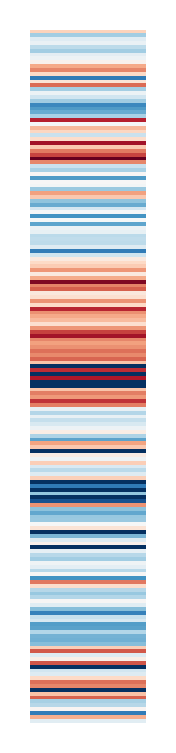

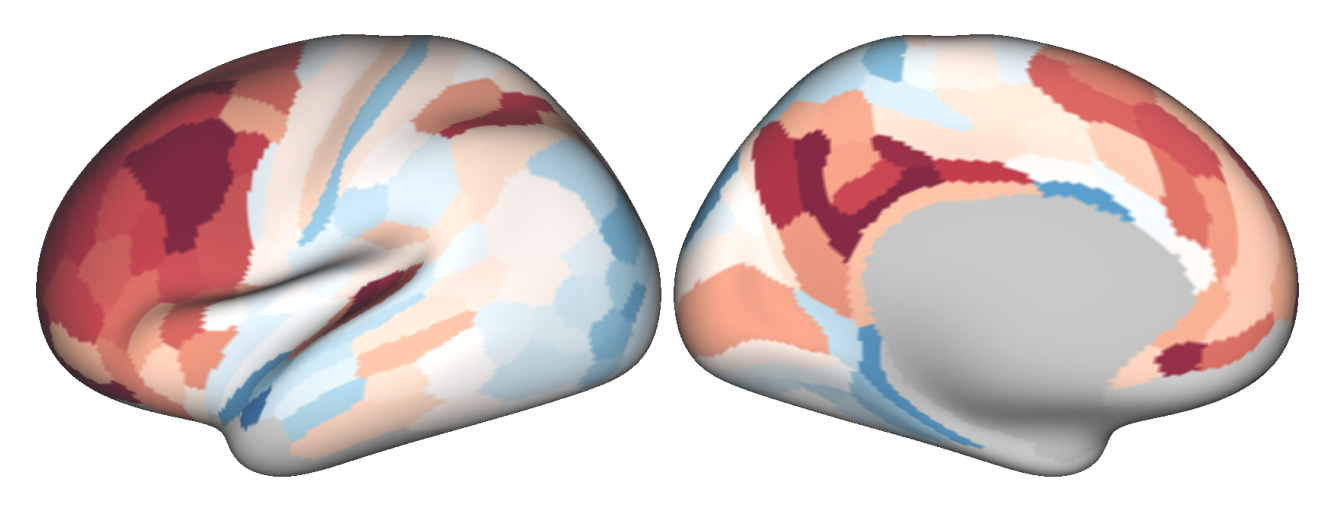

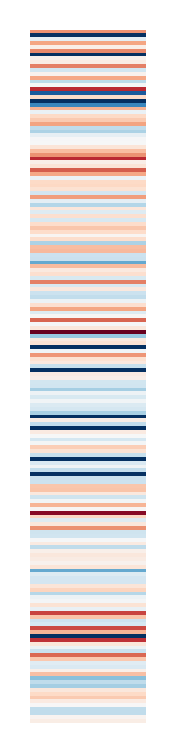

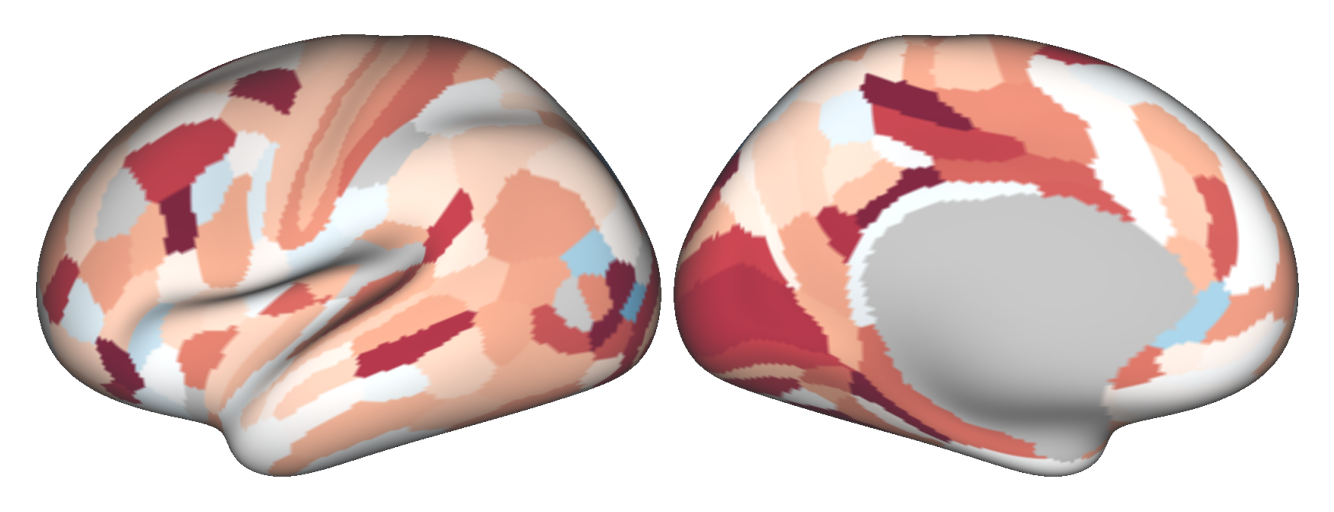

In [25]:
ahba_gene_expression = pd.read_csv(os.path.join(root_dir,'external','AHBA','allgenes_stable_r0.2_glasser_360.csv')) #Obtained using the function enigmatoolbox.datasets.fetch_ahba 
corr_ed_gexp = pd.DataFrame(columns=['gene','r','p'])
for gen in ahba_gene_expression.columns[1:]:
    gene_expression = ahba_gene_expression[gen].to_numpy()[:180]
    gene_expression[np.isnan(gene_expression)]=np.min(gene_expression)-1 if np.min(gene_expression)<0 else 0
    r_ed_gexp_p, p_ed_gexp_p = src.functions.corr_wo_outliers(avg_roi_ed_vals,gene_expression,n_mad=3.5)
    corr_ed_gexp = corr_ed_gexp.append({'gene':gen,'r':r_ed_gexp_p,'p':p_ed_gexp_p}, ignore_index=True)

_,corr_ed_gexp['p_fdr'] = pg.multicomp(corr_ed_gexp['p'].to_numpy().astype(np.float32),method='fdr_bh')

plt.figure(figsize=(6,2.5),dpi=fig_res_dpi)
sns.histplot(data=corr_ed_gexp, x="r",color=(0.6,0.6,0.6))
## Statsitical significance thresholds
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r<0)].r.max(), 0, 1, color='k', linestyle='dashed', lw=2)
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r>0)].r.min(), 0, 1, color='k', linestyle='dashed', lw=2)

hist_data = np.histogram_bin_edges(corr_ed_gexp.r.to_numpy(), bins=len(plt.gca().patches))
sel_genes_colors = [plt.cm.Dark2(range(8))[3].flatten(),plt.cm.Dark2(range(8))[3].flatten(),plt.cm.tab20c([4]).flatten()]
gene_ids_with_pet_available = np.array(['OPRM1','HTR4','CHRNA4']) # derived from figure 5E, but used here to don't duplicate the histogram there
for cix,sel_gene in enumerate(gene_ids_with_pet_available):
    patch_index = (np.abs((hist_data-corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.gene==sel_gene)].r.item()))).argmin()
    plt.gca().patches[patch_index].set_facecolor(sel_genes_colors[cix])
patch_index = (np.abs((hist_data-0))).argmin() #0 correlation gene
plt.gca().patches[patch_index].set_facecolor('gray')
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.gca().set_xlabel('Pearson correlation')

gene_exp_null_corr = ahba_gene_expression[corr_ed_gexp[(corr_ed_gexp.r>0) & (corr_ed_gexp.r<=0.000011)].gene.item()].to_numpy()[:180] # gen non-correlated with the energy density chosen arbitrary
gene_exp_null_corr[np.isnan(gene_exp_null_corr)]=np.min(gene_exp_null_corr)-1 if np.min(gene_exp_null_corr)<0 else 0
plt.figure(figsize=(0.5,3),dpi=fig_res_dpi)
sns.heatmap(avg_roi_ed_vals[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)
src.functions.plot_surf(avg_roi_ed_vals,os.path.join(results_dir,'figures',f'fig2C_surf_ecosts-avg'),cmap=ListedColormap(extended_cm),
                        show_colorbar=False,vlow=5,vhigh=95,generate_surf=False,fig_res_dpi=fig_res_dpi)

plt.figure(figsize=(0.5,3),dpi=fig_res_dpi)
sns.heatmap(gene_exp_null_corr[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)
src.functions.plot_surf(gene_exp_null_corr,
                        os.path.join(results_dir,'figures',f'fig4A_surf_nullcorr-{corr_ed_gexp[(corr_ed_gexp.r>0) & (corr_ed_gexp.r<=0.000011)].gene.item()}'),
                        show_colorbar=False,cmap=ListedColormap(extended_cm),vlow=5,vhigh=95,generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)



***Gene ontology (GO): cellular components***

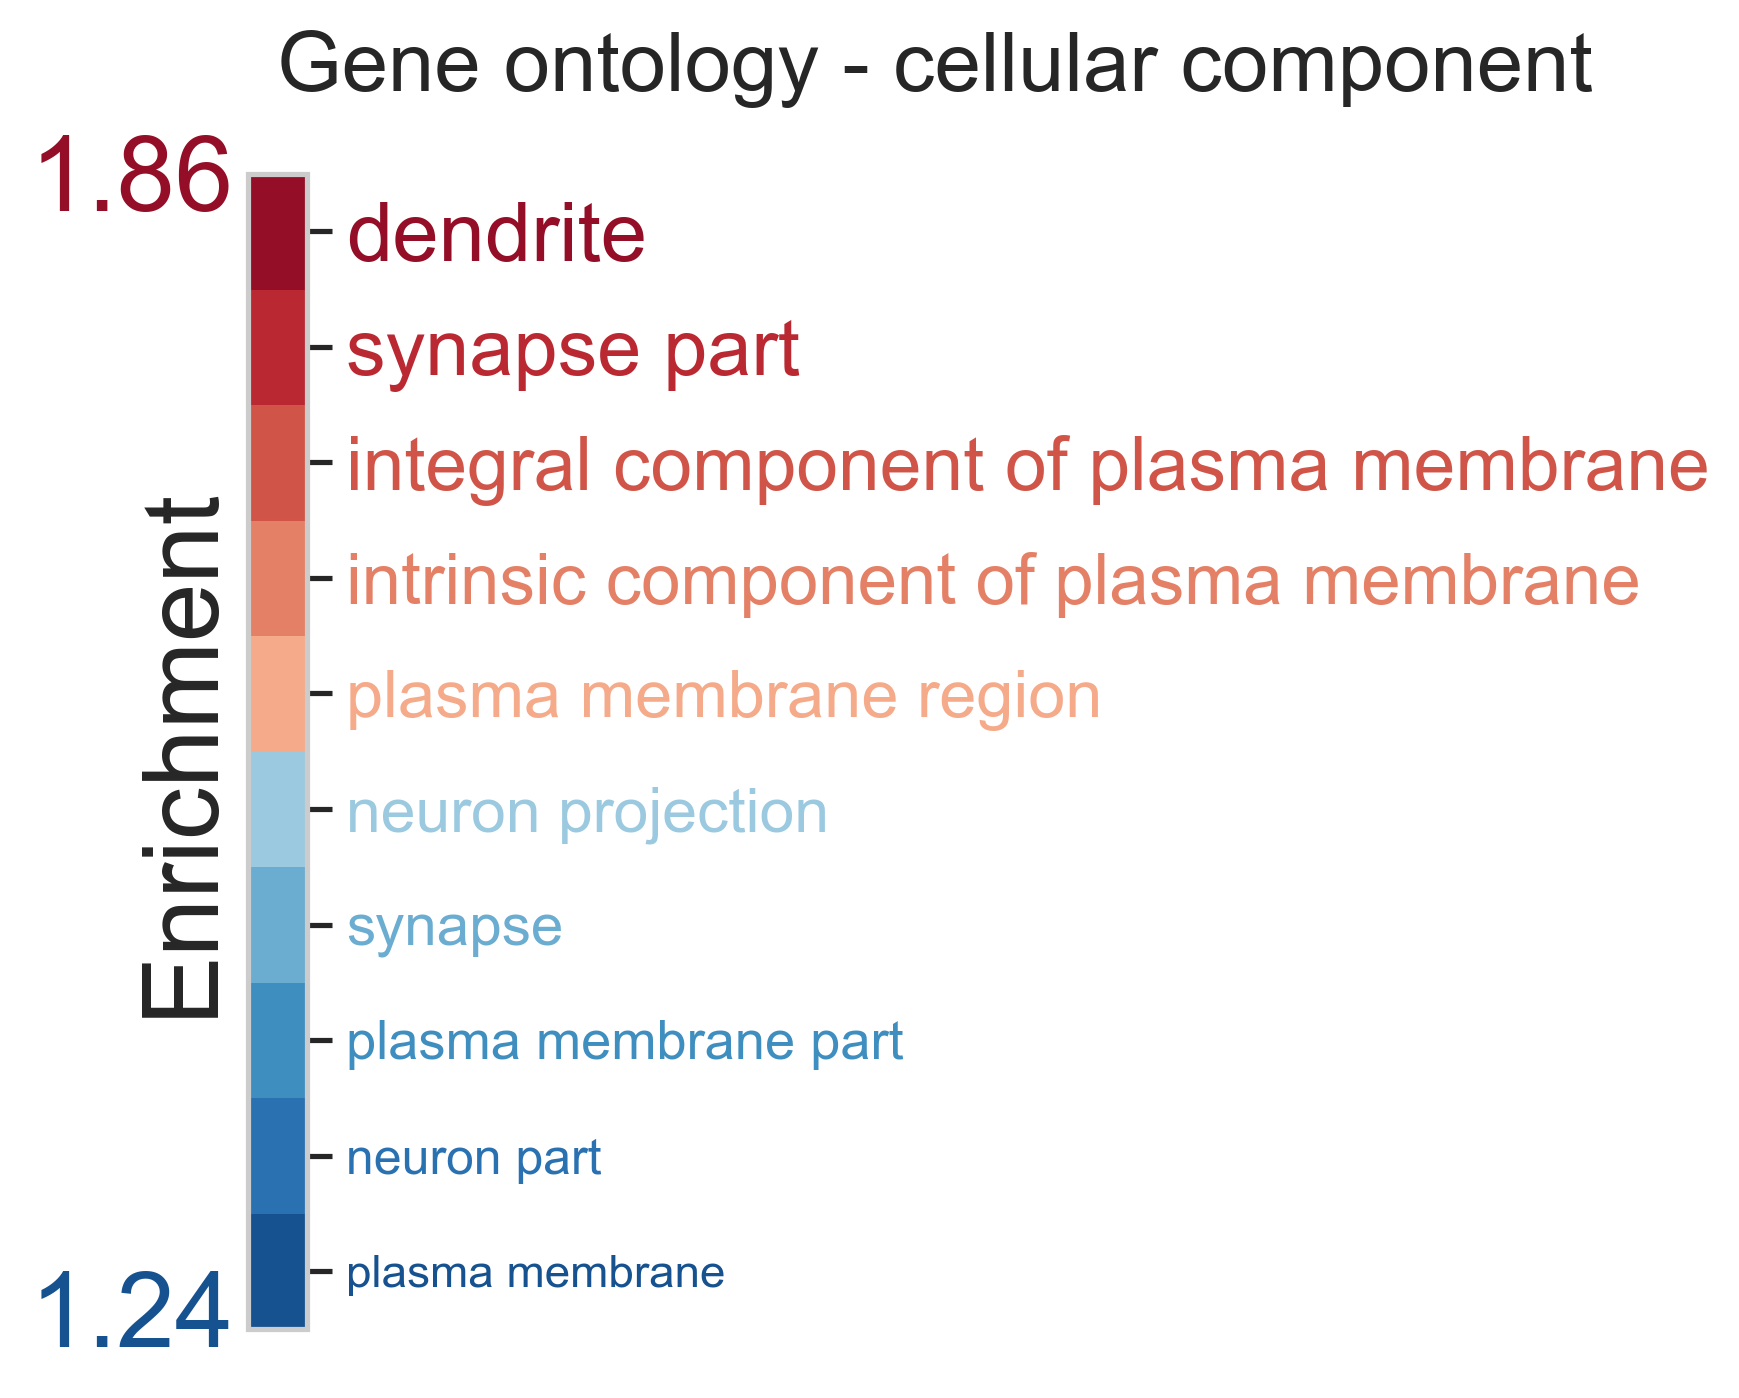

In [26]:
go_cell_comps = pd.read_csv(os.path.join(root_dir,'CompEnrichment_SD_AHBA_fdr0005_all_bgGTEx_Allsign.txt'),sep='\t')
go_cell_comps = go_cell_comps.sort_values(by='Enrichment',ignore_index=True) # Highest enrichment goes on the top
go_cell_comps['-log10(p_FDR)'] = -np.log10(go_cell_comps['FDR q-value'])

cix = 17
clrs_bar = []
for ix in range(go_cell_comps.shape[0]):
    clrs_bar+=[extended_cm[cix]]
    cix=cix+16 if cix!=81 else cix+16*6  
fig, ax = plt.subplots(figsize=(0.25,5),dpi=fig_res_dpi)
cb = colorbar.ColorbarBase(ax, cmap=ListedColormap(clrs_bar), orientation = 'vertical',ticks=np.arange(0.05,1,0.1))
go_cell_comps_tickl = go_cell_comps.Description.to_list()
cb.ax.set_yticklabels(go_cell_comps_tickl) 
for yix,ytickl in enumerate(cb.ax.get_yticklabels()):
    ytickl.set_color(clrs_bar[yix])
    ytickl.set_fontsize(10+yix+1)
cb.ax.text(-2, 0.05, go_cell_comps.loc[0,"Enrichment"],color=clrs_bar[0], transform=cb.ax.transAxes, va='top', ha='center')
cb.ax.text(-2, 0.95, go_cell_comps.loc[go_cell_comps.shape[0]-1,"Enrichment"],color=clrs_bar[-1], transform=cb.ax.transAxes, va='bottom', ha='center')
cb.ax.set_title( 'Gene ontology - cellular component',y=1.05,fontsize=20,fontdict={'horizontalalignment':'left'})
#cb.ax.set_title( r'$\bf{Enrichment}$ Gene ontology - cellular component',fontdict={'horizontalalignment':'left'})

cb.ax.set_ylabel('Enrichment', rotation=90)
cb.ax.yaxis.set_label_position('left')

***GO: molecular functions***

Text(0.0, 1.0, 'Enrichment')

<Figure size 3600x3300 with 0 Axes>

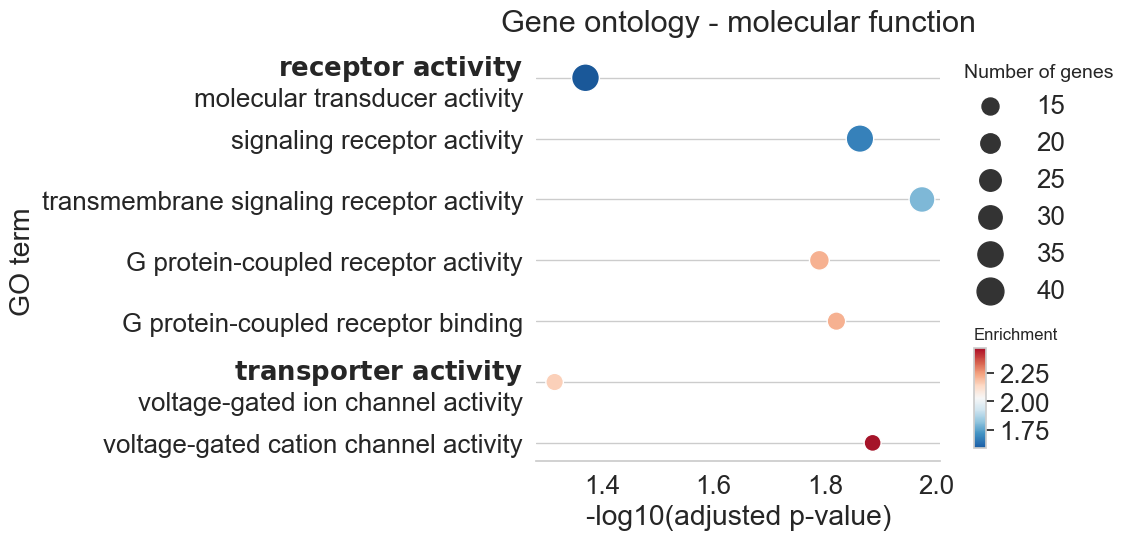

In [27]:
sns.set_context("notebook", font_scale=1.7)
go_mol_funcs = pd.read_csv(os.path.join(root_dir,'FPenrichment_SD_AHBA_fdr0005_all_bgGTEx_Allsign.txt'),sep='\t')
go_mol_funcs['-log10(adjusted p-value)'] = -np.log10(go_mol_funcs['FDR q-value'])
go_mol_funcs = go_mol_funcs.sort_values(by='FDR q-value',ignore_index=True,ascending=False)
go_mol_funcs['id']=go_mol_funcs.index+1
go_mol_funcs_sort_order={6:1,1:2,4:3,3:4,7:5,5:6,2:7}
go_mol_funcs['sorted_id'] = go_mol_funcs['id'].map(go_mol_funcs_sort_order)
go_mol_funcs.loc[go_mol_funcs.Description=='molecular transducer activity','Description'] = r'$\bf{receptor\ activity}$'+'\nmolecular transducer activity'
go_mol_funcs.loc[go_mol_funcs.Description=='voltage-gated ion channel activity','Description'] = r'$\bf{transporter\ activity}$'+'\nvoltage-gated ion channel activity'
go_mol_funcs = go_mol_funcs.sort_values(by='sorted_id',ignore_index=True,ascending=False)
plt.figure(figsize=(12,11),dpi=fig_res_dpi)
g = sns.relplot(data=go_mol_funcs, x="-log10(adjusted p-value)", y="sorted_id", hue="Enrichment",size="Number of genes",palette=ListedColormap(extended_cm[20:236]),sizes=(150,400))
plt.gca().set_yticks(go_mol_funcs.sorted_id.to_list())
plt.gca().set_yticklabels(go_mol_funcs.Description.to_list())
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['left'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().set_ylabel('GO term')
plt.gca().set_title('Gene ontology - molecular function',y=1.05,fontsize=22)
orig_leg = plt.gca().get_legend_handles_labels()
g._legend.remove()
leg = plt.legend(orig_leg[0][8:],orig_leg[1][8:],bbox_to_anchor=(1,1.05), loc="upper left", frameon=False,title=orig_leg[1][7],title_fontsize=14)
leg._legend_box.align = "left"
axins = inset_axes(g.ax,
                   width="3%",  # width = 3% of parent_bbox width
                   height="25%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.0, 1.05, 1.0),
                   bbox_transform=g.ax.transAxes
                   )
cbar = g.fig.colorbar(plt.cm.ScalarMappable(norm=clrs.Normalize(vmin=go_mol_funcs['Enrichment'].min(), vmax=go_mol_funcs['Enrichment'].max(), clip=False), cmap=ListedColormap(extended_cm[20:236])),cax=axins)
axins.set_title(orig_leg[1][0],fontsize=12,loc='left')

#### 4B. Summary genetics

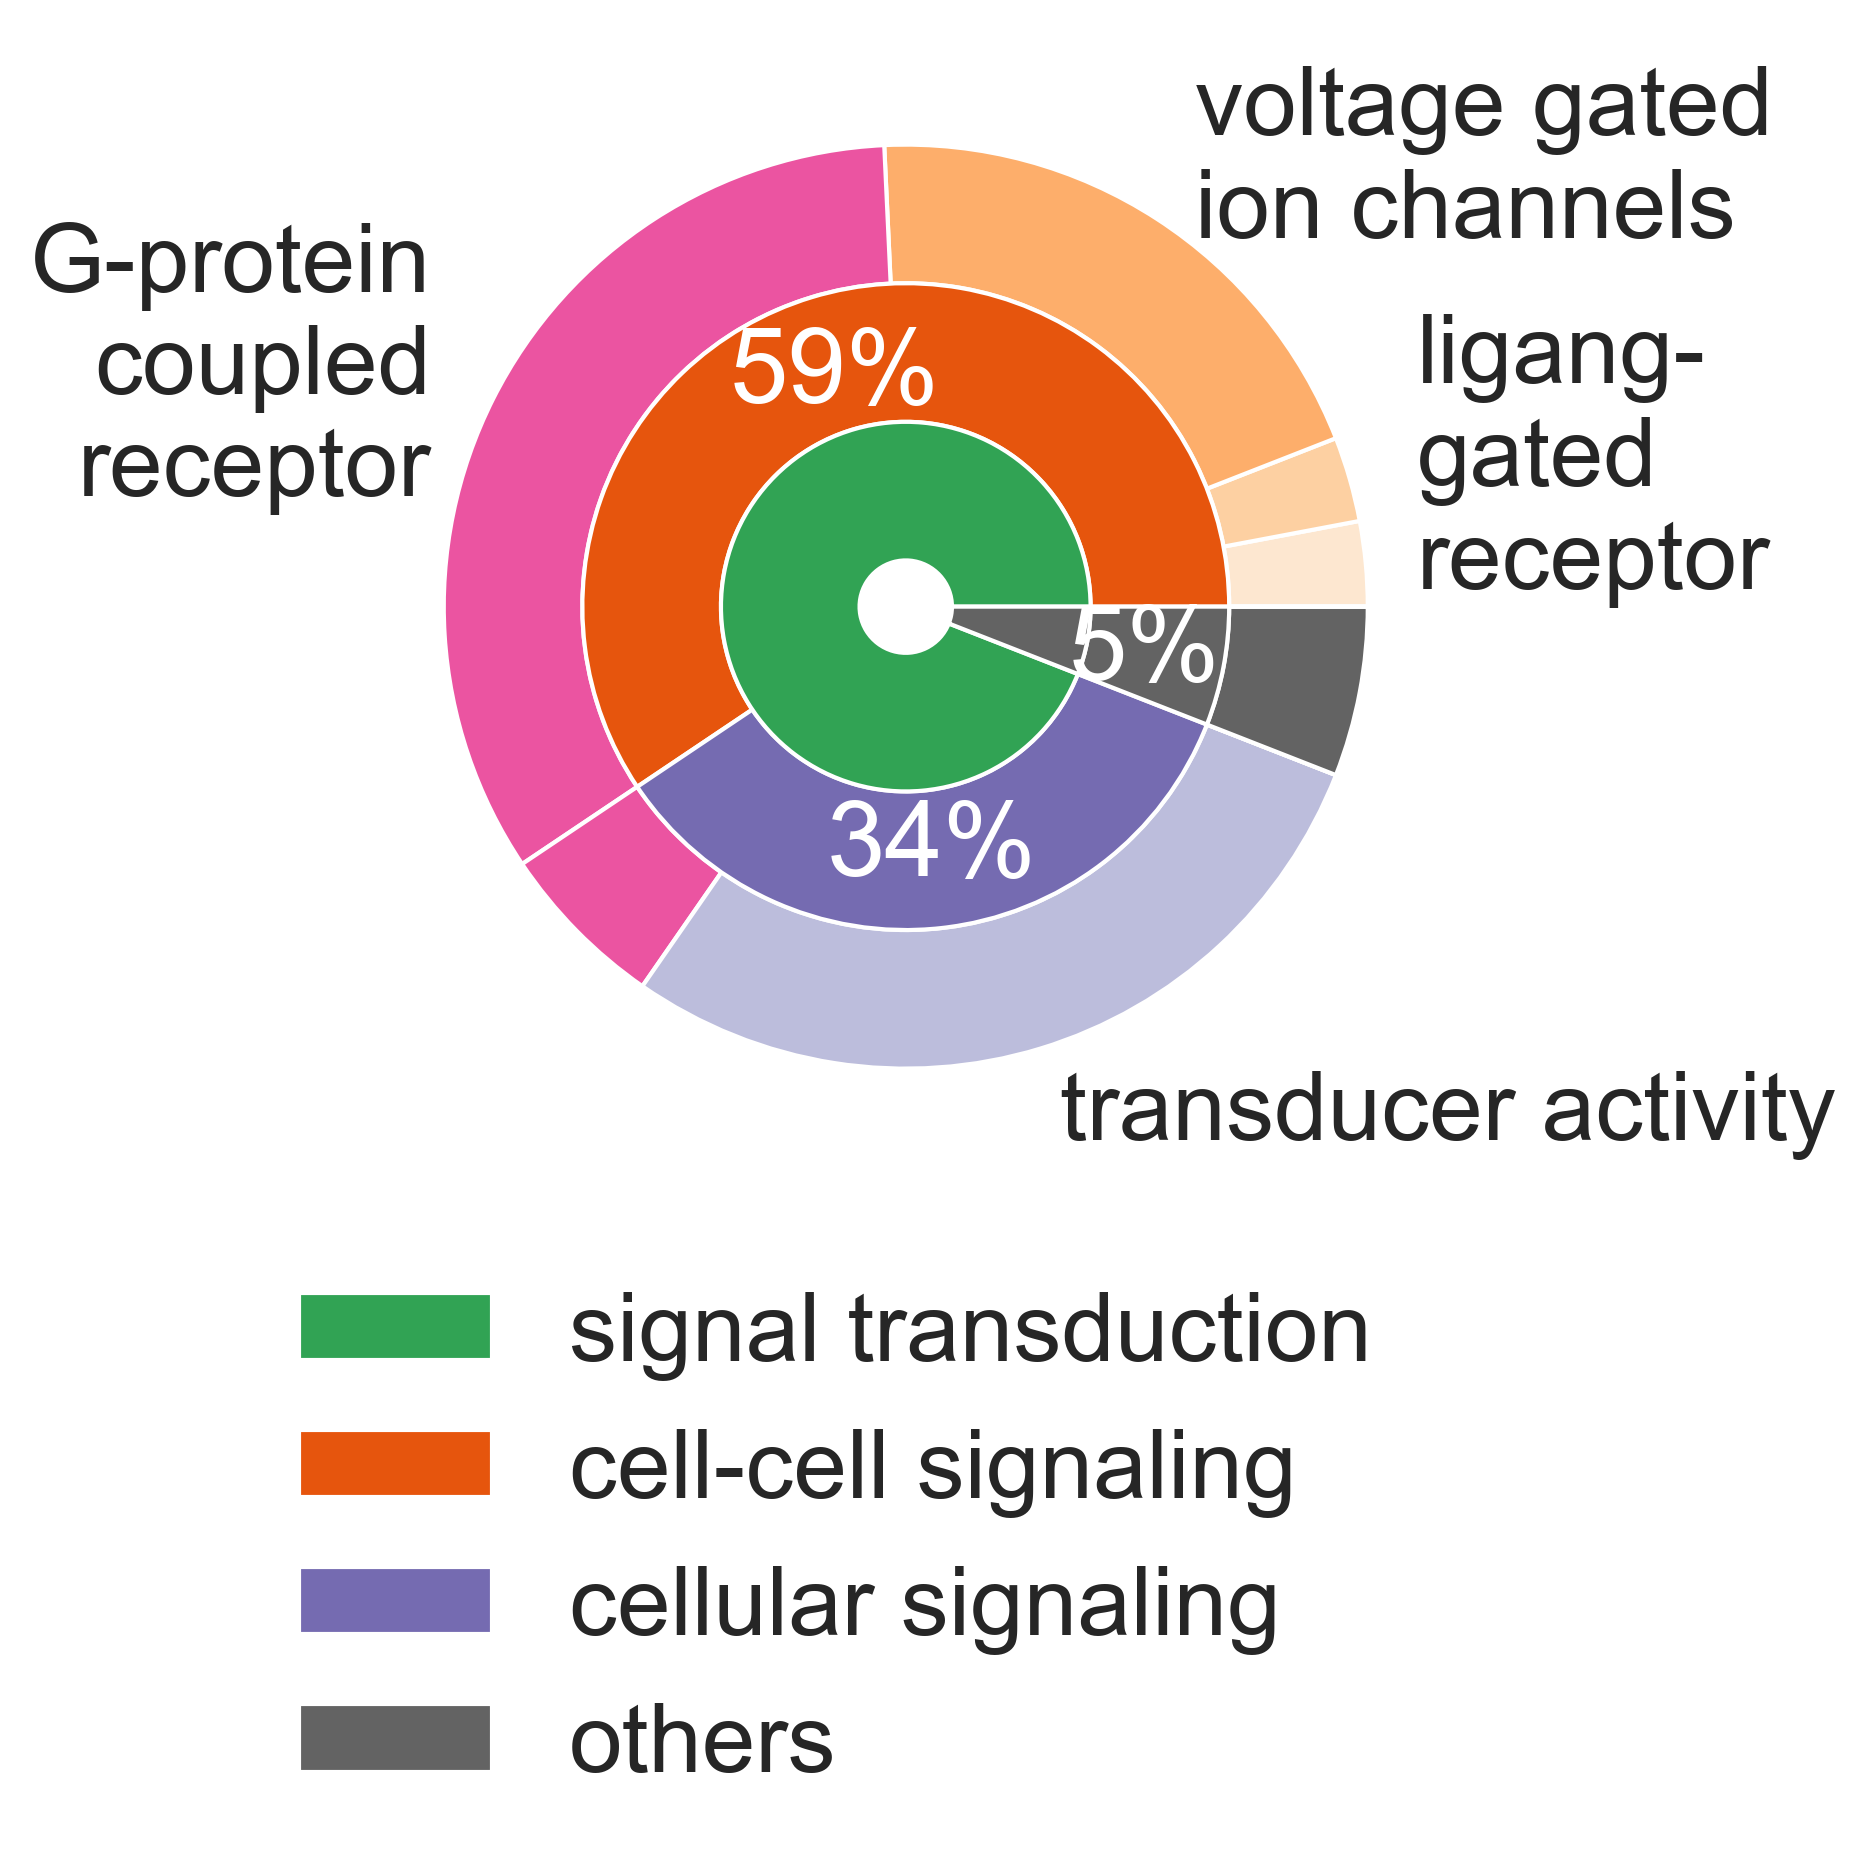

In [28]:
sns.set_context("notebook", font_scale=2.1)
go_genes = pd.read_excel(os.path.join(root_dir,'SD_AHBA_fdr0005_GTExbrainBG_GO_significant_genes.xlsx'),engine='openpyxl',usecols='A:I',nrows=70)
go_genes_summary = go_genes.groupby(['gene_type','gene_type_subcategory'],as_index=False).count()
total_genes = go_genes_summary.gene.sum()
go_genes_pie_data = np.concatenate((go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_numpy()[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0])[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='others'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0,0])[np.newaxis,:]
                                    ),axis=0)

go_genes_pie_data = np.round(100*go_genes_pie_data/total_genes)
go_genes_pie_labels = go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[1] = go_genes_pie_labels[0] #only valid because both categories have the same value
go_genes_pie_labels[0] = '' #others
## to make narrow the plot
go_genes_pie_labels[1] = 'ligang-\ngated\nreceptor'
go_genes_pie_labels[2] = 'voltage gated\nion channels'
go_genes_pie_labels[3] = 'G-protein\ncoupled\nreceptor'
go_genes_pie_labels += go_genes_summary.loc[(go_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[4] = '' #G protein duplicated
go_genes_pie_labels += ['','','','','','']

fig, ax = plt.subplots(figsize=(5,5),dpi=fig_res_dpi)
wd0,t0 = ax.pie(go_genes_pie_data.flatten(), radius=1,
                colors=np.concatenate((np.array(list(plt.cm.tab20c(range(20))[7][:3])+[0.5])[np.newaxis,:],plt.cm.tab20c(range(20))[np.arange(7,5,-1)],
                                       np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],
                                       plt.cm.tab20c(range(20))[14:16],np.concatenate((plt.cm.tab20c(range(20))[15][:3],[0.5]))[np.newaxis,:],
                                       np.repeat(np.array([plt.cm.tab20c(range(20))[16]]),4,axis=0)),axis=0),
                labels=go_genes_pie_labels,wedgeprops=dict(width=0.3, edgecolor='w'),labeldistance=1.15)

wd,_,_ =ax.pie(go_genes_pie_data.sum(axis=1), radius=0.7, colors=plt.cm.tab20c(range(20))[[4,12,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'),autopct='%d%%',textprops=dict(color="w"),pctdistance=0.75)
wd1,_ =ax.pie(np.array([np.sum(go_genes_pie_data[:2]),np.sum(go_genes_pie_data[-1])]), radius=0.4, colors=plt.cm.tab20c(range(20))[[8,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'))
ax.set(aspect="equal")
ax.legend([wd1[0]]+wd, ['signal transduction','cell-cell signaling','cellular signaling','others'],
          loc='lower left', ncol=1, bbox_to_anchor=(-0.1, -0.6),frameon=False)
#ax.legend([wd1[0]]+wd, ['signal transduction','cell-cell signaling','cellular signaling','others'],
#          loc='lower left', ncol=2, bbox_to_anchor=(-0.6, -0.3))

#### 4C. Chemoarchitecture mapping ####

[8.58765042e-01 7.11825449e-02 3.24448711e-02 1.78012481e-02
 7.55152129e-03 3.48653413e-03 2.89249287e-03 2.12769350e-03
 1.16956183e-03 8.47846064e-04 5.04625931e-04 3.36614905e-04]
[0.00019996 0.00019996 0.00019996 0.00019996 0.00019996 0.00019996
 0.00019996 0.00119976 0.00019996 0.03979204 0.0239952  0.14437113]
5HT1b:0.0001
5HT6:0.001
A4B2:0.049
D1:0.051
mGluR5:0.039
H3:0.22
Missing ROIs: [14, 60, 65, 66, 68, 77, 80, 88, 89, 90, 91, 92, 93, 95, 98, 110, 118, 119, 120, 122, 126, 131, 134, 135, 155, 160, 164, 165, 166, 170, 172, 178]


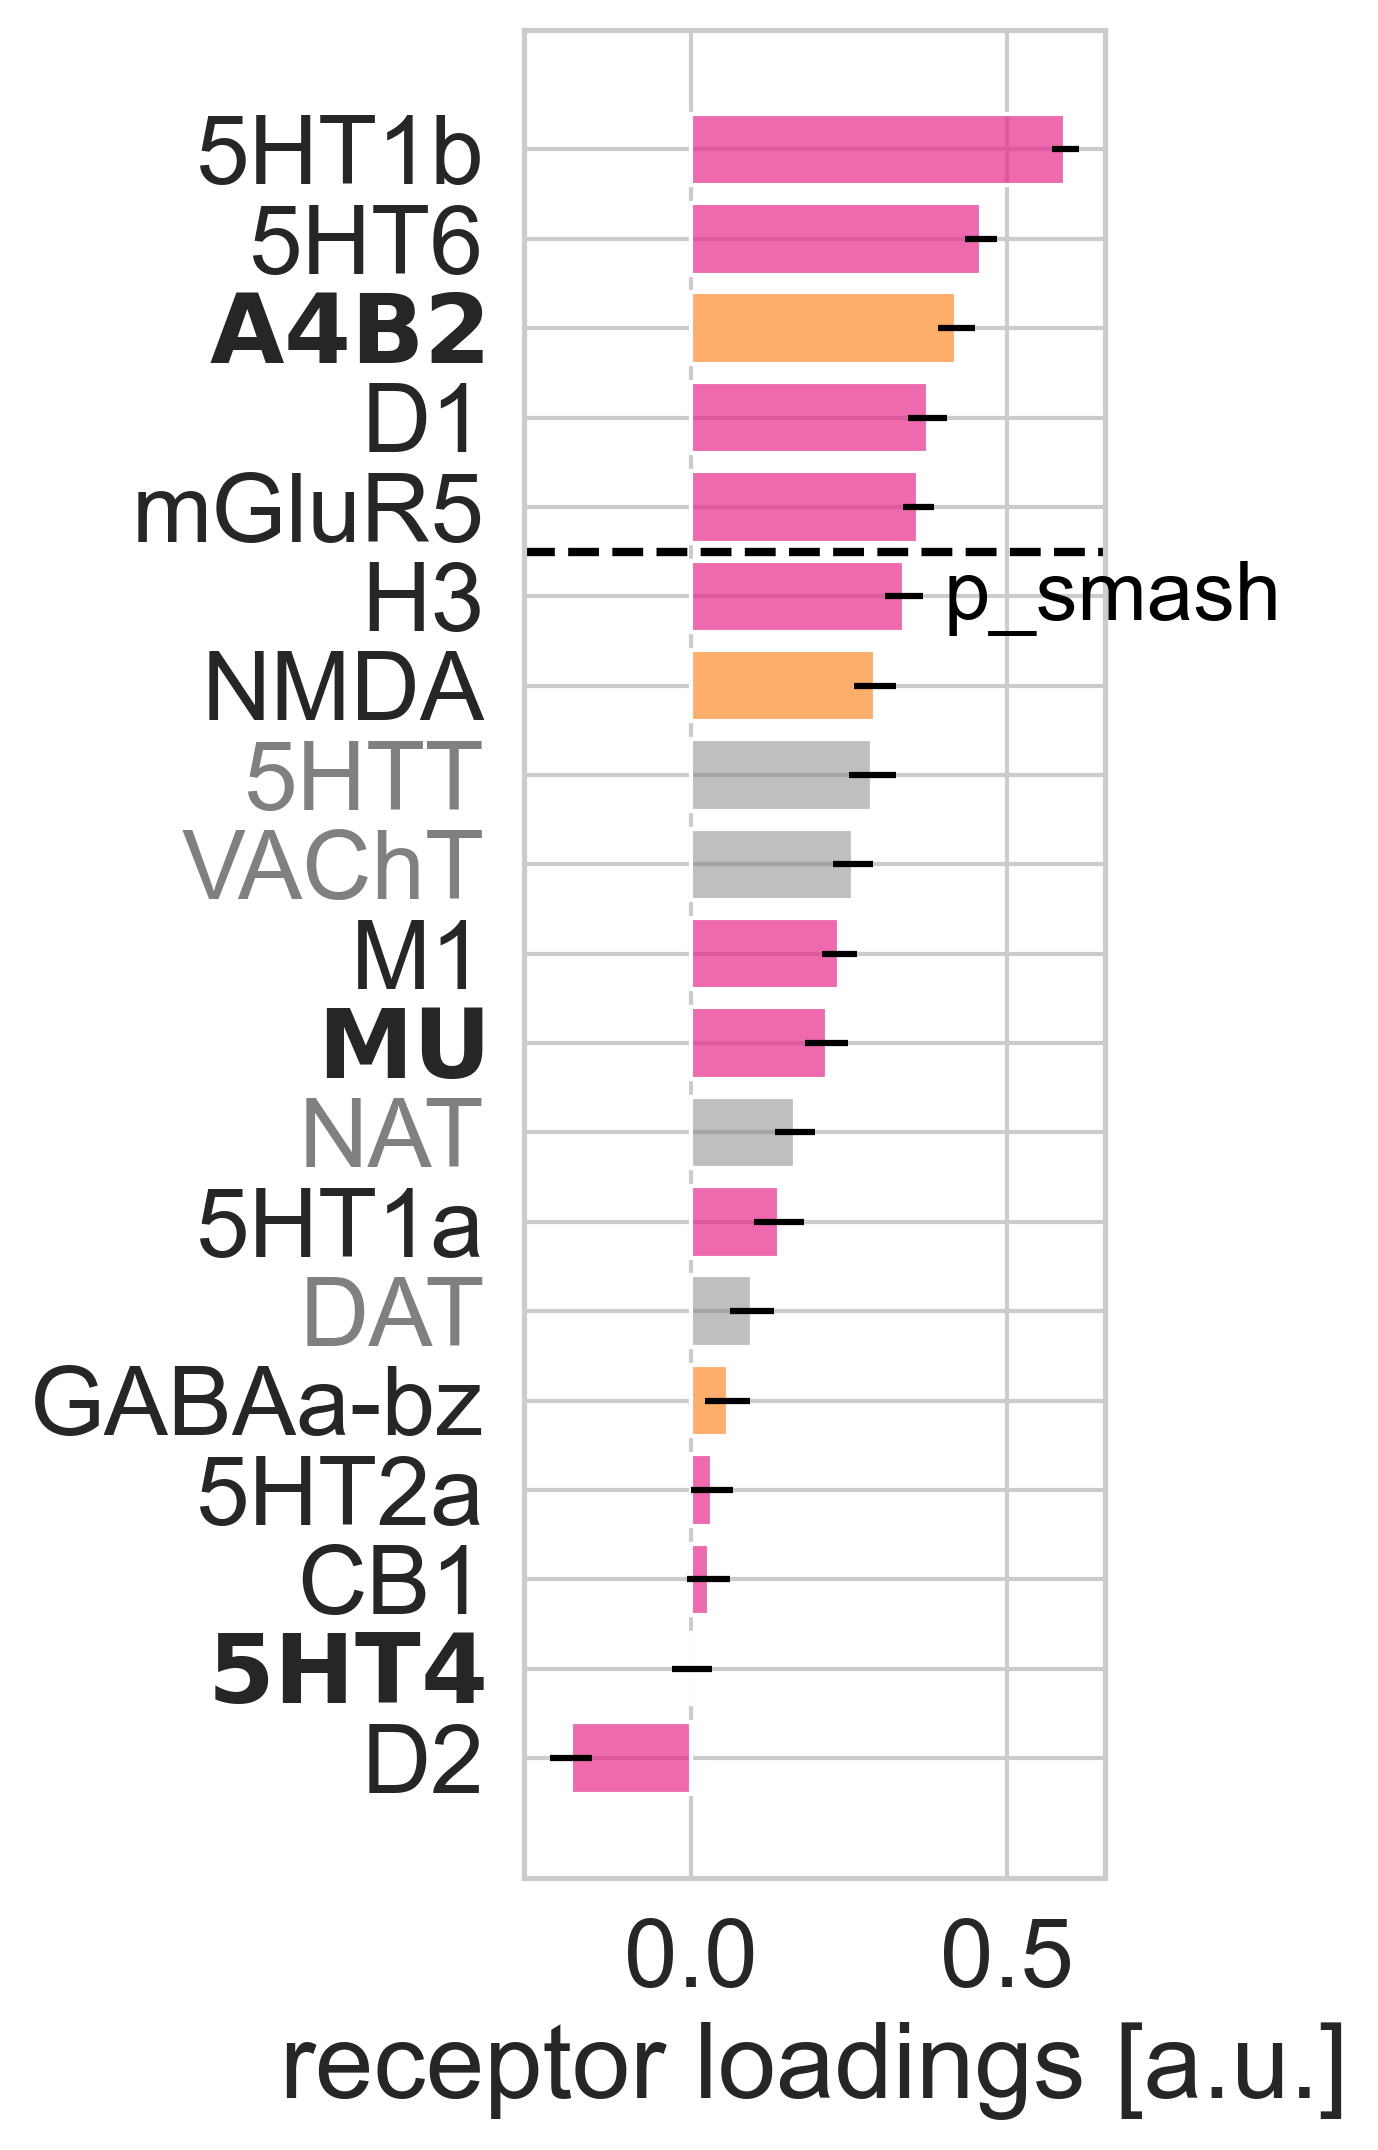

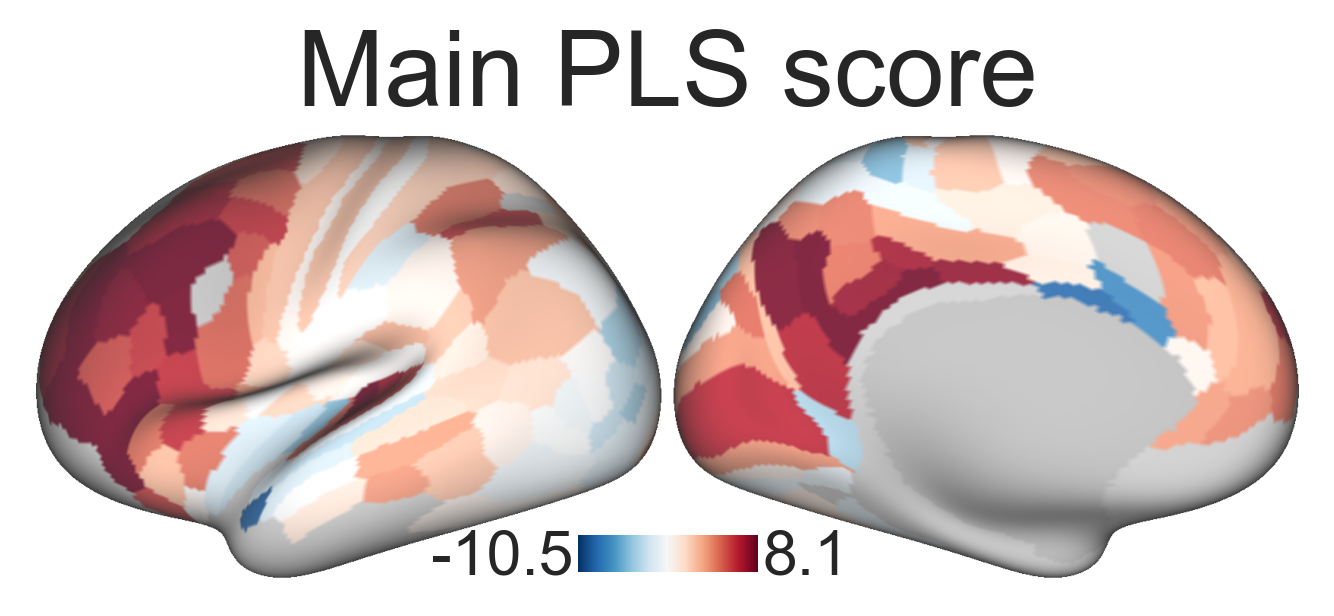

In [29]:
ed_vox_df = pd.read_csv(os.path.join(root_dir,f'individual_all-cohorts_vox_gx-mask_nsubj-{total_n_subj}_{conn_metric}-{dc_type}.csv.zip'))
ed_vox_df.drop(['Unnamed: 0'], axis = 1, inplace=True)
ext_pet_df = pd.read_csv(os.path.join(root_dir,'external','Hansen2021','Hansen2021_19-pet-tracers_vox.csv'))
ext_pet_df.drop(['Unnamed: 0'], axis = 1, inplace=True)
ext_pet_labels = ext_pet_df.columns[1:-2].to_list()
#PLS
if 'ecosts_ext_pet_vox_pls' in cohorts_metadata['all'].keys():
    ed_ext_pet_vox_pls = cohorts_metadata['all']['ecosts_ext_pet_vox_pls']
else:
    ed_ext_pet_vox_pls = pyls.behavioral_pls(stats.zscore(ed_vox_df[ed_vox_df.vox_id.isin(ext_pet_df.vox_id)].to_numpy()[:,1:], axis=0),ext_pet_df.to_numpy()[:,1:-2],n_perm=5000,n_boot=5000,n_proc=12)
n_vox_sign_comp = (ed_ext_pet_vox_pls['permres']['pvals']<=0.05).sum()
print(ed_ext_pet_vox_pls['varexp'][:n_vox_sign_comp])
print(ed_ext_pet_vox_pls['permres']['pvals'][:n_vox_sign_comp])

icx = 0 # Selected component

ext_pet_df['pls_x_score_0'] = ed_ext_pet_vox_pls['x_scores'][:,0]
ext_pet_roi_df = ext_pet_df.groupby('roi_id', as_index=False).median()
ext_pet_roi_df.loc[ext_pet_roi_df['roi_id']>180,'roi_id'] = ext_pet_roi_df.loc[ext_pet_roi_df['roi_id']>180,'roi_id'] - 20

pls_yloadings_p_df=pd.DataFrame()
for idx in range(ed_ext_pet_vox_pls['x_scores'].shape[1]):
    yload,yload_p = stats.pearsonr(ext_pet_df.to_numpy()[:,idx+1], ed_ext_pet_vox_pls['x_scores'][:,icx])
    pls_yloadings_p_df = pd.concat([pls_yloadings_p_df,pd.DataFrame({'label':[ext_pet_labels[idx]],'y_loading':[yload],'p_val':[yload_p]})],ignore_index=True)
_,pls_yloadings_p_df['p_val_fdr_bh'] = pg.multicomp(pls_yloadings_p_df['p_val'].to_numpy(),method='fdr_bh')

sorted_idx = np.argsort(ed_ext_pet_vox_pls["y_loadings"][:, icx])
pls_yloadings_p_df['p_smash'] = np.nan
for p_smash_cut,isx in enumerate(sorted_idx[::-1]): ##reverse vector
    if f'smash_pls0_pet-{ext_pet_labels[isx]}' not in cohorts_metadata['all'].keys():
        cohorts_metadata['all'][f'smash_pls0_pet-{ext_pet_labels[isx]}'] = src.functions.smash_comp(src.functions.metric2mmp(ext_pet_roi_df,'pls_x_score_0','roi_id'),src.functions.metric2mmp(ext_pet_roi_df,ext_pet_labels[isx],'roi_id'),
                                                                          lh_dist_full,y_nii_fn=os.path.join(results_dir,'figures',f'smash_pls0_pet-{ext_pet_labels[isx]}.png'),l=5,u=95,n_mad='min',
                                                                          p_uthr=1,plot=False,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False)
    rpar = pls_yloadings_p_df.loc[pls_yloadings_p_df.label==ext_pet_labels[isx],'y_loading'].item()
    pnpar = nonparp(rpar, cohorts_metadata['all'][f'smash_pls0_pet-{ext_pet_labels[isx]}'])
    pnpar = pnpar if pnpar>0 else 0.0001
    print(f'{ext_pet_labels[isx]}:{pnpar}')
    pls_yloadings_p_df.loc[pls_yloadings_p_df.label==ext_pet_labels[isx],'p_smash'] = pnpar
    if pnpar>0.055:
        break
        
ext_pet_colors = np.repeat(np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.7])[np.newaxis,:],len(ext_pet_labels),axis=0)
ext_pet_colors[5:7] = plt.cm.tab20c([6]).flatten()
ext_pet_colors[11] = plt.cm.tab20c([6]).flatten() #17
ext_pet_colors[16] = plt.cm.tab20c([6]).flatten() #17
ext_pet_colors[17] = plt.cm.tab20c([6]).flatten()
ext_pet_colors[np.isin(np.array(ext_pet_labels),np.array(['5HTT','DAT','NAT','VAChT']))] = [0.5,0.5,0.5,0.5]

fig, axs = plt.subplots(1, 1, figsize=(2.5, 8),dpi=fig_res_dpi)
ext_pet_colors_mod = ext_pet_colors.copy()
err = (ed_ext_pet_vox_pls["bootres"]["y_loadings_ci"][:, icx, 1] - ed_ext_pet_vox_pls["bootres"]["y_loadings_ci"][:, icx, 0]) / 2
sorted_idx = np.argsort(ed_ext_pet_vox_pls["y_loadings"][:, icx])#[::-1] 
significance_index = np.zeros(len(ext_pet_labels), dtype=bool)    
axs.barh(np.arange(len(err)), np.sort(ed_ext_pet_vox_pls["y_loadings"][:, icx]),xerr=err[sorted_idx],color=ext_pet_colors_mod[sorted_idx])
axs.set_yticks(np.arange(len(ed_ext_pet_vox_pls["y_loadings"])))#, labels=ext_pet_roi_df.columns[1:].to_numpy()[relidx])

for ext_pet_idx in [ipx for ipx,ext_pet_label in enumerate(ext_pet_labels) if ext_pet_label in ['5HT4','A4B2','MU']]:
    ext_pet_labels[ext_pet_idx] = r'$\bf{'+ext_pet_labels[ext_pet_idx]+'}$'

axs.set_yticklabels(np.array(ext_pet_labels)[sorted_idx]) #(ext_pet_roi_maps.columns[1:].to_numpy()[sorted_idx])
axs.set_xlabel("receptor loadings [a.u.]")

for ext_pet_idx in [ipx for ipx,ext_pet_label in enumerate(np.array(ext_pet_labels)[sorted_idx]) if ext_pet_label in ['5HTT','DAT','NAT','VAChT']]:
    axs.get_yticklabels()[ext_pet_idx].set_color([0.5,0.5,0.5])

axs.axhline(len(ext_pet_labels)-p_smash_cut-0.5, 0, 1, color='k', linestyle='dashed', lw=2)
axs.text(0.4, len(ext_pet_labels)-p_smash_cut-0.6, 'p_smash', ha='left',va='top', color='k',fontsize=20)

src.functions.plot_surf(src.functions.metric2mmp(pd.DataFrame({'roi_id':ext_pet_df.roi_id.to_numpy(),'ed_pls_score':ed_ext_pet_vox_pls['x_scores'][:,icx]}),'ed_pls_score','roi_id'),
                        os.path.join(results_dir,'figures',f'fig5C_surf_PLS'),cmap=ListedColormap(extended_cm),
                        show_colorbar=True,vlow=5,vhigh=95,fig_title='Main PLS score',generate_surf=generate_surf,fig_res_dpi=fig_res_dpi)



***Validation of relationship between energy density and receptor density expression from receptor-PET imaging***

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]


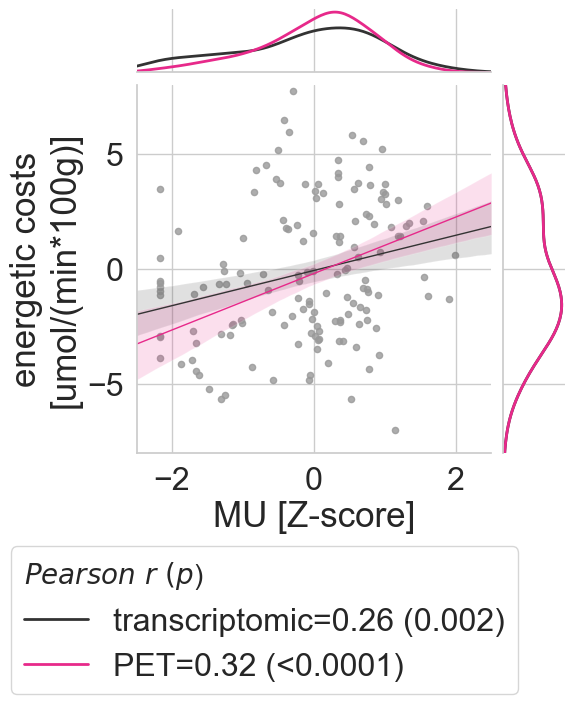

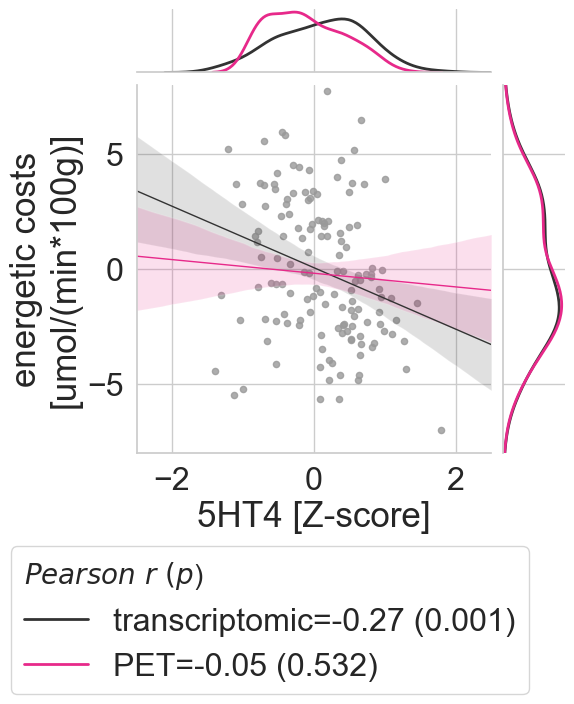

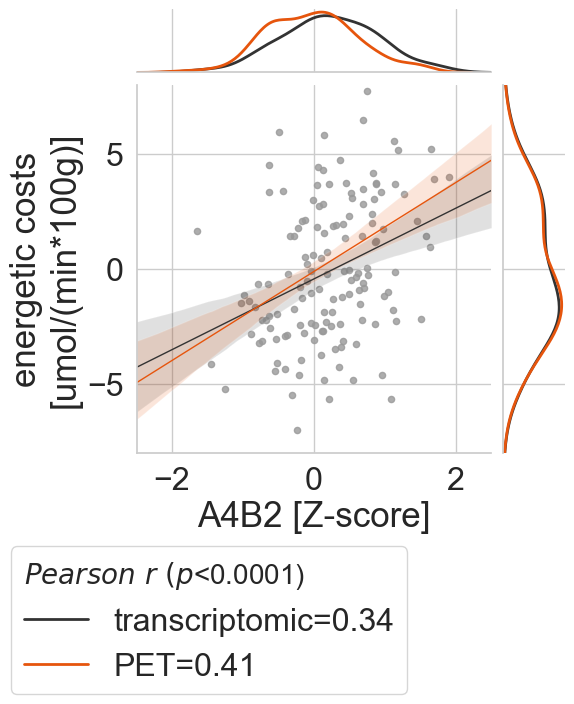

In [30]:
selected_genes=['OPRM1','HTR4','CHRNA4']
selected_tracers=['MU','5HT4','A4B2']
sel_genexp_df = ahba_gene_expression.loc[:179,selected_genes].reset_index() 
sel_genexp_df.rename(columns={'index': 'roi_id'}, inplace=True)
sel_genexp_df['roi_id']+=1

sel_genexp_df[sel_genexp_df.columns[sel_genexp_df.columns!='roi_id']] = sel_genexp_df[sel_genexp_df.columns[sel_genexp_df.columns!='roi_id']].apply(stats.zscore,nan_policy='omit')

genexp_pet_df = ext_pet_roi_df[ext_pet_roi_df.roi_id<181].loc[:,selected_tracers+['roi_id']].merge(sel_genexp_df,on='roi_id',how='left').merge(pd.DataFrame({'energetic_costs':src.functions.metric2mmp(all_avg_roi_vals,'energetic_costs','roi_id'),'roi_id':np.arange(1,181)}),on='roi_id',how='left')
genexp_pet_df = genexp_pet_df.melt(['roi_id','energetic_costs'], var_name='neurotransmitter',ignore_index=False)
genexp_pet_df['variable'] = 'PET'
genexp_pet_df.loc[genexp_pet_df.neurotransmitter.isin(selected_genes),'variable'] = 'transcriptomic'
genexp_pet_df.loc[genexp_pet_df.neurotransmitter.isin(selected_genes),'neurotransmitter'] = genexp_pet_df.loc[genexp_pet_df.neurotransmitter.isin(selected_genes),'neurotransmitter'].map(
dict(zip(selected_genes, selected_tracers)))


for nt in selected_tracers:
    pet_color = plt.cm.Dark2(range(8))[3].flatten() if nt!='A4B2' else plt.cm.tab20c([4]).flatten()
    src.functions.multiple_joinplot(genexp_pet_df,'value','energetic_costs',[((genexp_pet_df.neurotransmitter==nt) & (genexp_pet_df.variable=='transcriptomic')),((genexp_pet_df.neurotransmitter==nt) & (genexp_pet_df.variable=='PET'))],
                      [],['transcriptomic','PET'],[(0.2,0.2,0.2,1),pet_color],(0.6,0.6,0.6,0.6),s=20,xlim=(-2.5,2.5),ylim=(-8,8),
                      xlabel=nt+' [Z-score]',ylabel='energetic costs\n[umol/(min*100g)]',legend_bbox_to_anchor=(-0.4,-0.7),plot_legend=True,mad_thr=3.5,print_ci=False)
    
    

#### 4D. Cognitive mapping ####

<Figure size 1920x1440 with 0 Axes>

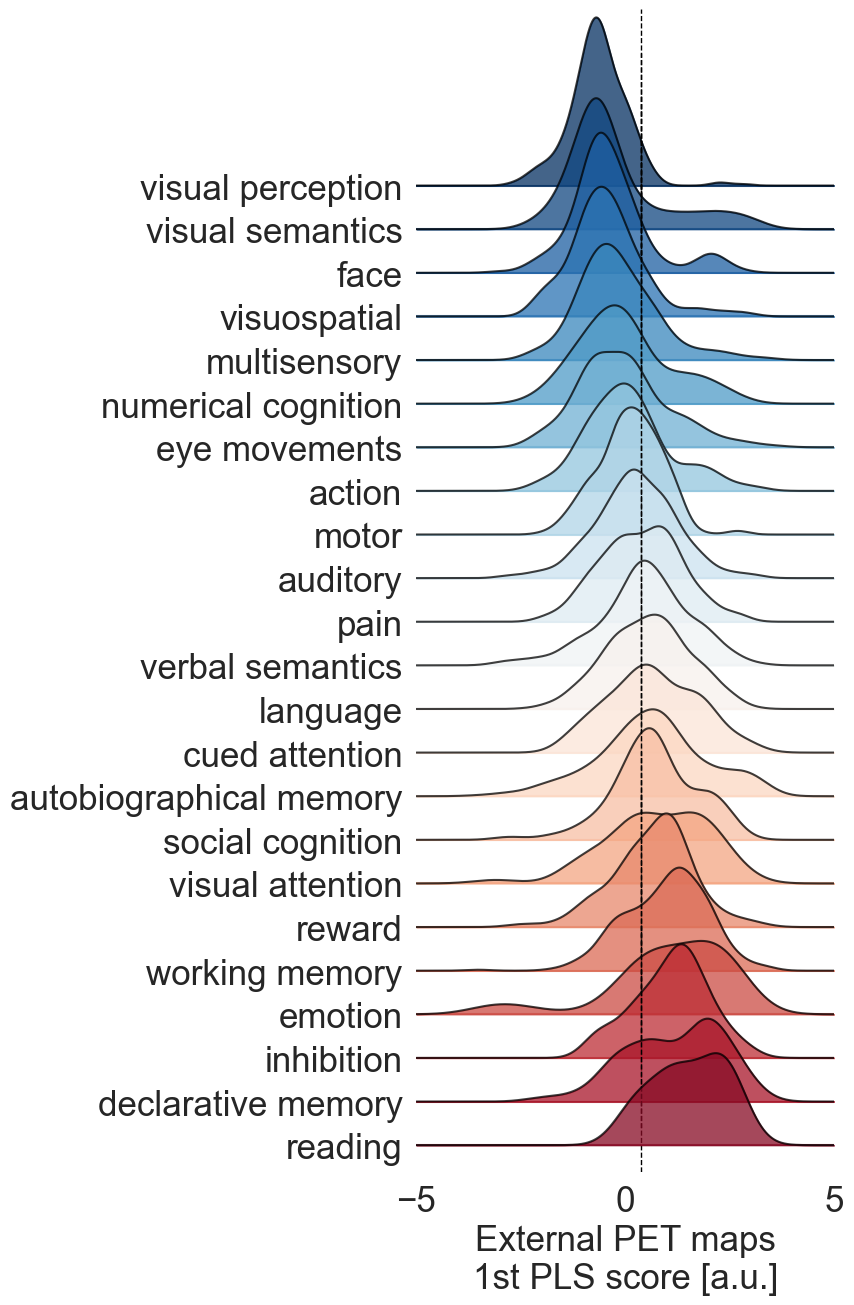

In [51]:
neurosynth_masks_df = pd.read_csv(os.path.join(root_dir,f'gx_neurosynth_z-2.3-xscore0_pls-median_cohorts-all_vox_nsubj-30_{conn_metric}-{dc_type}.csv'))
neurosynth_order = neurosynth_masks_df[neurosynth_masks_df.ext_pet_vox_pls_0!=0.0].groupby('domain', as_index=False).median().sort_values(by='ext_pet_vox_pls_0',ignore_index=True)
neurosynth_order['sorted_domain'] = neurosynth_order.index.astype(str).str.zfill(2)+'-'+neurosynth_order.domain
sorted_domain_map = dict(zip(neurosynth_order['domain'],neurosynth_order['sorted_domain']))
neurosynth_masks_df['sorted_domain'] = neurosynth_masks_df['domain'].map(sorted_domain_map)
plt.figure(dpi=fig_res_dpi)
joypy.joyplot(
    neurosynth_masks_df,#[neurosynth_masks_df.signal_density!=0.0],#[neurosynth_masks_df.inefficiency!=0.0],
    by="sorted_domain",
    column="ext_pet_vox_pls_0",#figsize=(5,8),
    colormap=plt.cm.RdBu_r,
    alpha=0.75,
    figsize=(9,13),
    labels=list(neurosynth_masks_df.sort_values(by='sorted_domain',ignore_index=True)['domain'].unique()),
    #fade=True
)#,overlap=3)#,x_range=[0,110])
plt.gca().set_xlim([-5,5])
plt.gca().set_xlabel('External PET maps\n1st PLS score [a.u.]')
for axx in plt.gcf().get_axes()[:-1]:
    axx.axvline(0, 0, 1, color='k', linestyle='dashed', lw=1)#,zorder=7)